## 1.Environment Setup

In [62]:
# Import thư viện cần thiết
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score

warnings.filterwarnings('ignore')

# Đặt seed để đảm bảo kết quả nhất quán giữa các lần chạy
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
print(f"Seed: {SEED}")

Seed: 42


## 2.Data Processing

In [63]:
#!gdown 16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju

In [64]:
!gdown --fuzzy 'https://drive.google.com/file/d/1SOQO4eAKRcUmNP3sOwKkMWrFP7T7niGK/view?usp=sharing'

Downloading...
From: https://drive.google.com/uc?id=1SOQO4eAKRcUmNP3sOwKkMWrFP7T7niGK
To: /content/heart.csv
100% 38.1k/38.1k [00:00<00:00, 93.5MB/s]


In [65]:
data_1 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data', header=None, na_values='?')
data_2 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', header=None, na_values='?')
data_3 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data', header=None, na_values='?')
data_4 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data', header=None, na_values='?')
data_5 = pd.read_csv('/content/heart.csv', na_values='?')
COLUMNS = ['age','sex','cp','trestbps','chol','fbs','restecg',
           'thalach','exang','oldpeak','slope','ca','thal','target']
data_1.columns = COLUMNS
data_2.columns = COLUMNS
data_3.columns = COLUMNS
data_4.columns = COLUMNS

data_1.dropna(how='all', inplace=True)
data_5

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


### Data Preprocessing

In [66]:
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, MinMaxScaler

In [67]:
# DATA_PATH = 'cleveland.csv'
COLUMNS = ['age','sex','cp','trestbps','chol','fbs','restecg',
           'thalach','exang','oldpeak','slope','ca','thal','target']

numeric_cols = ['age','trestbps','chol','thalach','oldpeak']
categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

K_features = 10

raw = pd.concat([data_1, data_2, data_3, data_4, data_5], ignore_index=True)
#raw.columns = COLUMNS

for c in ['age','trestbps','chol','thalach','oldpeak','ca','thal']:
    raw[c] = pd.to_numeric(raw[c], errors='coerce')


raw['target'] = (raw['target'] > 0).astype(int)
print("Shape:", raw.shape)
display(raw.head())
display(raw.isna().sum())

Shape: (1945, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,28.0,1.0,2.0,130.0,132.0,0.0,2.0,185.0,0.0,0.0,NaN,NaN,NaN,0
1,29.0,1.0,2.0,120.0,243.0,0.0,0.0,160.0,0.0,0.0,NaN,NaN,NaN,0
2,29.0,1.0,2.0,140.0,NaN,0.0,0.0,170.0,0.0,0.0,NaN,NaN,NaN,0
3,30.0,0.0,1.0,170.0,237.0,0.0,1.0,170.0,0.0,0.0,NaN,NaN,6.0,0
4,31.0,0.0,2.0,100.0,219.0,0.0,1.0,150.0,0.0,0.0,NaN,NaN,NaN,0


,0
age,0
sex,0
cp,0
trestbps,59
chol,30
fbs,90
restecg,2
thalach,55
exang,55
oldpeak,62


In [68]:
# https://drive.google.com/drive/folders/1cMoqIDEgGYDVzv8B7cKp3csxujQ4OFp7?usp=drive_link
# !gdown --folder 1cMoqIDEgGYDVzv8B7cKp3csxujQ4OFp7

In [69]:
def read_csv(file_path):
    print(f"{file_path}")
    df = pd.read_csv(file_path)
    display(df.head())

    X = df.drop('target', axis=1)
    y = df['target']
    display(y.value_counts())

    print("Shape df: ", df.shape)
    print("Shape X: ", X.shape)
    print("Shape y: ", y.shape)

    return X, y

In [70]:
TARGET = 'target'
raw_feature_cols = [c for c in raw.columns if c != TARGET]

X_all = raw[raw_feature_cols]
y_all = raw[TARGET]

X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.4, stratify=y_all, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [71]:
cat_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', MinMaxScaler())
])
num_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer([
    ('num', num_proc, numeric_cols),
    ('cat', cat_proc, categorical_cols),
])
raw_pipeline = Pipeline([
    ('preprocess', preprocess),
])

X_raw_train = raw_pipeline.fit_transform(X_train, y_train)
X_raw_val = raw_pipeline.transform(X_val)
X_raw_test = raw_pipeline.transform(X_test)

preprocessed_feature_names = []

for name, transformer, columns in preprocess.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        preprocessed_feature_names.extend(transformer.get_feature_names_out(columns))
    else:
        preprocessed_feature_names.extend(columns)

# Build DataFrames with feature names
X_raw_train_df = pd.DataFrame(
    X_raw_train, columns=preprocessed_feature_names, index=X_train.index
)
X_raw_val_df = pd.DataFrame(
    X_raw_val, columns=preprocessed_feature_names, index=X_val.index
)
X_raw_test_df = pd.DataFrame(
    X_raw_test, columns=preprocessed_feature_names, index=X_test.index
)

# Save to CSV
out_dir = Path('splits')
out_dir.mkdir(parents=True, exist_ok=True)

pd.concat([X_raw_train_df, y_train.rename(TARGET)], axis=1).to_csv(
    out_dir / 'raw_train.csv', index=False
)
pd.concat([X_raw_val_df, y_val.rename(TARGET)], axis=1).to_csv(
    out_dir / 'raw_val.csv', index=False
)
pd.concat([X_raw_test_df, y_test.rename(TARGET)], axis=1).to_csv(
    out_dir / 'raw_test.csv', index=False
)

# Display DataFrame
display(X_raw_train_df)

,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal
1645,0.682231,0.967803,0.406458,0.545631,1.441105,0.0,0.00,0.0,0.0,0.0,0.333333,0.50,0.428571
306,0.244056,-0.102591,0.383733,-0.049909,-0.340147,1.0,0.75,1.0,1.0,1.0,0.666667,0.25,0.857143
472,-1.180012,-0.102591,1.054101,0.744144,0.817666,1.0,0.75,0.0,0.0,0.0,0.333333,0.25,0.428571
655,0.244056,-0.905387,-2.524980,-2.432068,-1.765149,1.0,1.00,0.0,0.5,0.0,0.333333,0.00,0.428571
1353,-1.837275,-0.102591,0.315560,1.736711,2.242668,1.0,0.50,0.0,0.5,0.0,0.000000,0.00,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,1.449037,-0.637788,-2.524980,0.267712,0.461416,1.0,1.00,1.0,0.0,0.0,1.000000,0.00,0.428571
1218,-2.056362,-0.530749,-0.343445,1.220576,-0.874523,1.0,0.25,0.0,0.5,0.0,0.666667,0.00,0.285714
518,1.010863,-1.280025,0.531441,1.022063,0.728604,0.0,1.00,0.0,0.0,1.0,0.666667,0.50,0.428571
135,-0.084575,0.432606,1.110912,0.744144,-0.874523,1.0,0.50,0.0,0.0,0.0,0.666667,0.00,0.428571


In [72]:
# Combine feature engineering and preprocessing
dt_feature_selection_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('decision_tree', DecisionTreeClassifier(random_state=42))
])

# Fit the pipeline
dt_feature_selection_pipeline.fit(X_train, y_train)

# Extract feature importances
# Need to update feature names after preprocessing and feature engineering
processed_feature_names = []
# Get the feature names after preprocessing
preprocessor = dt_feature_selection_pipeline.named_steps['preprocess']
for name, transformer, columns in preprocessor.transformers_:
     if hasattr(transformer, 'get_feature_names_out'):
        processed_feature_names.extend(transformer.get_feature_names_out(columns))
     else:
        processed_feature_names.extend(columns)

feature_importance_series = pd.Series(
    dt_feature_selection_pipeline.named_steps['decision_tree'].feature_importances_,
    index=processed_feature_names
)

# Sort features by importance
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)
display(sorted_feature_importances)

# Select top K features
selected_features = sorted_feature_importances.head(K_features).index.tolist()
print(f'Top {K_features} selected features: {selected_features}')

# Filter datasets by selected features
# Need to apply the first part of the pipeline (feature adding and preprocessing) to get the transformed dataframes
X_train_processed = Pipeline(dt_feature_selection_pipeline.steps[:-1]).transform(X_train)
X_val_processed = Pipeline(dt_feature_selection_pipeline.steps[:-1]).transform(X_val)
X_test_processed = Pipeline(dt_feature_selection_pipeline.steps[:-1]).transform(X_test)

# Convert to DataFrames with correct column names
X_train_processed_df = pd.DataFrame(X_train_processed, columns=processed_feature_names, index=X_train.index)
X_val_processed_df = pd.DataFrame(X_val_processed, columns=processed_feature_names, index=X_val.index)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=processed_feature_names, index=X_test.index)


X_dt_train = X_train_processed_df[selected_features]
X_dt_val = X_val_processed_df[selected_features]
X_dt_test = X_test_processed_df[selected_features]

display(X_dt_train.head())

# Save reduced datasets to CSV
pd.concat([X_dt_train, y_train.rename(TARGET)], axis=1).to_csv(
    out_dir / 'dt_train.csv', index=False
)
pd.concat([X_dt_val, y_val.rename(TARGET)], axis=1).to_csv(
    out_dir / 'dt_val.csv', index=False
)
pd.concat([X_dt_test, y_test.rename(TARGET)], axis=1).to_csv(
    out_dir / 'dt_test.csv', index=False
)

,0
cp,0.220848
chol,0.131505
age,0.102201
oldpeak,0.095396
ca,0.088210
thalach,0.077990
thal,0.074968
trestbps,0.050477
sex,0.047746
exang,0.037765


Top 10 selected features: ['cp', 'chol', 'age', 'oldpeak', 'ca', 'thalach', 'thal', 'trestbps', 'sex', 'exang']


,cp,chol,age,oldpeak,ca,thalach,thal,trestbps,sex,exang
1645,0.00,0.406458,0.682231,1.441105,0.50,0.545631,0.428571,0.967803,0.0,0.0
306,0.75,0.383733,0.244056,-0.340147,0.25,-0.049909,0.857143,-0.102591,1.0,1.0
472,0.75,1.054101,-1.180012,0.817666,0.25,0.744144,0.428571,-0.102591,1.0,0.0
655,1.00,-2.524980,0.244056,-1.765149,0.00,-2.432068,0.428571,-0.905387,1.0,0.0
1353,0.50,0.315560,-1.837275,2.242668,0.00,1.736711,0.285714,-0.102591,1.0,0.0


In [73]:
def add_new_features_func(df):
    df = df.copy()
    if {'chol', 'age'} <= set(df.columns):
        df['chol_per_age'] = df['chol'] / df['age']
    if {'trestbps', 'age'} <= set(df.columns):
        df['bps_per_age'] = df['trestbps'] / df['age']
    if {'thalach', 'age'} <= set(df.columns):
        df['hr_ratio'] = df['thalach'] / df['age']
    if 'age' in df.columns:
        df['age_bin'] = pd.cut(df['age'], bins=5, labels=False).astype('category')
    return df

# ---------------------------
# Transformer class wrapper
# ---------------------------

from sklearn.base import BaseEstimator, TransformerMixin
class AddNewFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.columns_ = X.columns
        self.new_features_ = []
        if {'chol', 'age'} <= set(X.columns):
            self.new_features_.append('chol_per_age')
        if {'trestbps', 'age'} <= set(X.columns):
            self.new_features_.append('bps_per_age')
        if {'thalach', 'age'} <= set(X.columns):
            self.new_features_.append('hr_ratio')
        if 'age' in X.columns:
            self.new_features_.append('age_bin')
        return self

    def transform(self, X):
        return add_new_features_func(X)

    def get_feature_names_out(self, input_features=None):
        return list(self.columns_) + self.new_features_

# ---------------------------
# Feature groups
# ---------------------------
gen_num = ['chol_per_age', 'bps_per_age', 'hr_ratio']
gen_cat = ['age_bin']

all_nums = [c for c in numeric_cols] + gen_num
all_cats = [c for c in categorical_cols] + gen_cat

# ---------------------------
# Preprocessing pipelines
# ---------------------------
num_proc = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc', StandardScaler())
])

cat_proc = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ---------------------------
# Full pipeline with feature engineering + preprocessing
# ---------------------------
pre = ColumnTransformer([
    ('num', num_proc, all_nums),
    ('cat', cat_proc, all_cats),
], verbose_feature_names_out=False).set_output(transform='pandas')

fe_pre = Pipeline([
    ('add', AddNewFeaturesTransformer()),
    ('pre', pre),
]).set_output(transform='pandas')

# ---------------------------
# Transform datasets
# ---------------------------
Xt_tr = fe_pre.fit_transform(X_train, y_train)
Xt_va = fe_pre.transform(X_val)
Xt_te = fe_pre.transform(X_test)

# ---------------------------
# Remove constant (non-varying) columns
# ---------------------------
nz_cols = Xt_tr.columns[Xt_tr.nunique(dropna=False) > 1]

Xt_tr = Xt_tr[nz_cols]
Xt_va = Xt_va[nz_cols]
Xt_te = Xt_te[nz_cols]

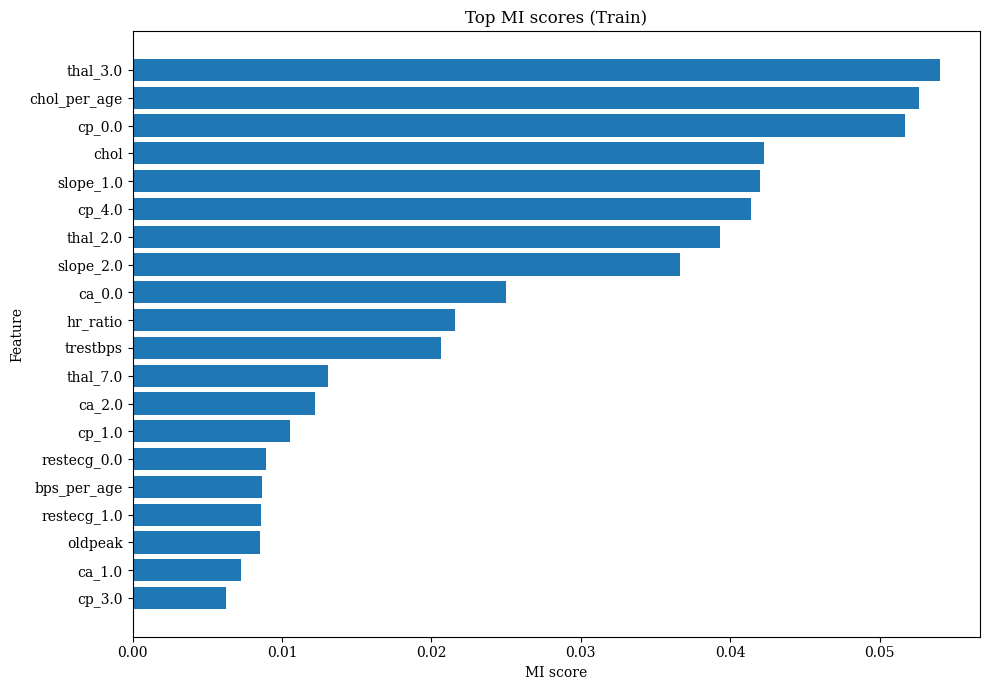

,fe_topk_features
0,thal_3.0
1,chol_per_age
2,cp_0.0
3,chol
4,slope_1.0
5,cp_4.0
6,thal_2.0
7,slope_2.0
8,ca_0.0
9,hr_ratio


In [74]:
ohe = fe_pre.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
cat_names = list(ohe.get_feature_names_out(all_cats))

is_discrete = np.array([c in cat_names for c in Xt_tr.columns], dtype=bool)

mi = mutual_info_classif(
    Xt_tr.values, y_train.values,
    discrete_features=is_discrete,
    random_state=42
)

mi_series = pd.Series(mi, index=Xt_tr.columns).sort_values(ascending=False)

# Select top N features
N = min(20, len(mi_series))
topN = mi_series.head(N).iloc[::-1]

# Plot MI scores
plt.figure(figsize=(10, max(6, 0.35 * N)))
plt.barh(topN.index, topN.values)
plt.title('Top MI scores (Train)')
plt.xlabel('MI score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('top_mi_scores.pdf', bbox_inches='tight')
plt.show()

# Select top K features based on raw columns (excluding target)
K = raw.columns.drop('target').shape[0]
topk_cols = list(mi_series.head(K).index)

# Create feature-engineered datasets
fe_tr = Xt_tr[topk_cols].assign(target=y_train.values)
fe_va = Xt_va[topk_cols].assign(target=y_val.values)
fe_te = Xt_te[topk_cols].assign(target=y_test.values)

# Save datasets
out = Path('splits')
out.mkdir(parents=True, exist_ok=True)

fe_tr.to_csv(out / 'fe_train.csv', index=False)
fe_va.to_csv(out / 'fe_val.csv', index=False)
fe_te.to_csv(out / 'fe_test.csv', index=False)

# Display top features
display(
    pd.Series(topk_cols, name='fe_topk_features').reset_index(drop=True)
)

In [75]:
dt_fe_feature_selection_pipeline = Pipeline([
    ('preprocess', fe_pre),
    ('decision_tree', DecisionTreeClassifier(random_state=42))
])

# Fit pipeline
dt_fe_feature_selection_pipeline.fit(X_train, y_train)

# Extract feature names from preprocessing step
pipeline_feature_names = dt_fe_feature_selection_pipeline.named_steps['preprocess'].get_feature_names_out()

# Compute feature importances
feature_importance_series = pd.Series(
    dt_fe_feature_selection_pipeline.named_steps['decision_tree'].feature_importances_,
    index=pipeline_feature_names
)

# Sort by importance
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)
display(sorted_feature_importances)

# Select top K features
selected_features = sorted_feature_importances.head(K_features).index.tolist()
print(f'Top {K_features} selected features: {selected_features}')

# Reduce datasets to selected features
X_fe_dt_train = Xt_tr[selected_features]
X_fe_dt_val = Xt_va[selected_features]
X_fe_dt_test = Xt_te[selected_features]

display(X_fe_dt_train.head())

# Save datasets with selected features
pd.concat([X_fe_dt_train, y_train.rename(TARGET)], axis=1).to_csv(
    out_dir / 'fe_dt_train.csv', index=False
)
pd.concat([X_fe_dt_val, y_val.rename(TARGET)], axis=1).to_csv(
    out_dir / 'fe_dt_val.csv', index=False
)
pd.concat([X_fe_dt_test, y_test.rename(TARGET)], axis=1).to_csv(
    out_dir / 'fe_dt_test.csv', index=False
)

,0
chol_per_age,0.122672
cp_4.0,0.111779
thal_3.0,0.105296
oldpeak,0.080546
hr_ratio,0.071255
trestbps,0.060860
chol,0.057647
age,0.048524
thalach,0.047122
ca_0.0,0.046999


Top 10 selected features: ['chol_per_age', 'cp_4.0', 'thal_3.0', 'oldpeak', 'hr_ratio', 'trestbps', 'chol', 'age', 'thalach', 'ca_0.0']


,chol_per_age,cp_4.0,thal_3.0,oldpeak,hr_ratio,trestbps,chol,age,thalach,ca_0.0
1645,0.027161,0.0,1.0,1.441105,-0.199137,0.967803,0.406458,0.682231,0.545631,0.0
306,0.176252,0.0,0.0,-0.340147,-0.293268,-0.102591,0.383733,0.244056,-0.049909,0.0
472,1.689062,0.0,1.0,0.817666,1.138971,-0.102591,1.054101,-1.180012,0.744144,0.0
655,-2.334758,1.0,1.0,-1.765149,-1.539113,-0.905387,-2.524980,0.244056,-2.432068,1.0
1353,1.376616,0.0,0.0,2.242668,2.635029,-0.102591,0.315560,-1.837275,1.736711,1.0


### Data Synthesis

In [76]:
!pip install sdv

In [77]:
from sdv.datasets.local import load_csvs
from sdv.metadata import Metadata
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, CopulaGANSynthesizer
from sdv.utils import load_synthesizer

def synthetic_data(data, file_path, num_rows=100, save=True):
    """
    Generates synthetic data from a pandas DataFrame and saves it to a specified path.

    Args:
        data (pd.DataFrame): The original DataFrame.
        file_path (str): The path where the synthetic data will be saved.
        save (bool): Whether to save the synthetic data to a CSV file.
        num_rows (int): nuber of rows that you want to generate.
    Returns:
        tuple: A tuple containing the new DataFrame (original + synthetic) and the save file path.
    """
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    metadata = Metadata.detect_from_dataframe(data=data)
    synthesizer = CopulaGANSynthesizer(metadata)
    synthesizer.fit(data)
    synthetic_data = synthesizer.sample(num_rows=num_rows)
    new_data = pd.concat([data, synthetic_data], ignore_index=True)
    dir_name = os.path.dirname(file_path)
    new_file_name = f"{base_name}_synthetic.csv"
    new_file_path = os.path.join(dir_name, new_file_name)
    if save:
        new_data.to_csv(new_file_path, index=False)
        print(f"✅ Saved synthetic dataset to: {new_file_path}")
    return new_data, new_file_path

def synthetic(file_path, num_rows=100, save=True):
    data = pd.read_csv(file_path)
    return synthetic_data(data, file_path, num_rows=num_rows, save=save)

### 2.1 Original Dataset

In [78]:
X_train, y_train = read_csv('splits/raw_train.csv')
X_val, y_val = read_csv('splits/raw_val.csv')
X_test, y_test = read_csv('splits/raw_test.csv')

splits/raw_train.csv


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,0.682231,0.967803,0.406458,0.545631,1.441105,0.0,0.00,0.0,0.0,0.0,0.333333,0.50,0.428571,0
1,0.244056,-0.102591,0.383733,-0.049909,-0.340147,1.0,0.75,1.0,1.0,1.0,0.666667,0.25,0.857143,1
2,-1.180012,-0.102591,1.054101,0.744144,0.817666,1.0,0.75,0.0,0.0,0.0,0.333333,0.25,0.428571,0
3,0.244056,-0.905387,-2.524980,-2.432068,-1.765149,1.0,1.00,0.0,0.5,0.0,0.333333,0.00,0.428571,1
4,-1.837275,-0.102591,0.315560,1.736711,2.242668,1.0,0.50,0.0,0.5,0.0,0.000000,0.00,0.285714,1


,count
target,
1,621
0,546


Shape df:  (1167, 14)
Shape X:  (1167, 13)
Shape y:  (1167,)
splits/raw_val.csv


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,-0.851381,-0.637788,0.304198,0.029496,-0.162022,1.0,0.00,0.0,0.0,0.0,0.666667,0.0,0.428571,0
1,1.558581,-0.637788,-0.127564,-1.121881,0.461416,0.0,0.50,0.0,0.0,0.0,0.333333,0.0,0.285714,1
2,-1.727731,-0.637788,0.099679,1.538197,2.509856,1.0,0.75,0.0,0.5,1.0,0.333333,0.0,0.428571,0
3,0.134513,-0.102591,0.065593,0.069199,-0.162022,1.0,0.75,0.0,0.5,0.0,0.666667,0.0,0.428571,1
4,0.572688,1.503000,0.576890,-0.724854,-0.874523,1.0,0.75,0.0,0.0,0.0,0.666667,0.0,0.285714,0


,count
target,
1,207
0,182


Shape df:  (389, 14)
Shape X:  (389, 13)
Shape y:  (389,)
splits/raw_test.csv


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,-0.960925,-1.065946,-0.707034,-0.208720,-0.874523,0.0,0.25,0.0,0.5,0.0,0.333333,0.00,0.285714,1
1,1.449037,-0.637788,0.076955,-0.566044,1.441105,1.0,0.00,0.0,0.0,1.0,0.333333,0.50,0.428571,0
2,0.463144,-0.102591,0.463268,-0.129314,0.906729,1.0,1.00,0.0,0.0,1.0,0.666667,0.00,0.428571,1
3,0.901319,-0.102591,0.463268,-1.836529,0.194228,0.0,0.50,0.0,0.5,0.0,0.333333,0.25,0.428571,0
4,-1.837275,-0.637788,0.429182,-0.526341,-0.874523,0.0,0.50,0.0,0.0,0.0,0.666667,0.00,0.428571,0


,count
target,
1,207
0,182


Shape df:  (389, 14)
Shape X:  (389, 13)
Shape y:  (389,)


### 2.2 FE Dataset

In [79]:
X_fe_train, y_fe_train = read_csv('splits/fe_train.csv')
X_fe_val, y_fe_val = read_csv('splits/fe_val.csv')
X_fe_test, y_fe_test = read_csv('splits/fe_test.csv')

splits/fe_train.csv


,thal_3.0,chol_per_age,cp_0.0,chol,slope_1.0,cp_4.0,thal_2.0,slope_2.0,ca_0.0,hr_ratio,trestbps,thal_7.0,ca_2.0,target
0,1.0,0.027161,1.0,0.406458,1.0,0.0,0.0,0.0,0.0,-0.199137,0.967803,0.0,1.0,0
1,0.0,0.176252,0.0,0.383733,0.0,0.0,0.0,1.0,0.0,-0.293268,-0.102591,0.0,0.0,1
2,1.0,1.689062,0.0,1.054101,1.0,0.0,0.0,0.0,0.0,1.138971,-0.102591,0.0,0.0,0
3,1.0,-2.334758,0.0,-2.524980,1.0,1.0,0.0,0.0,1.0,-1.539113,-0.905387,0.0,0.0,1
4,0.0,1.376616,0.0,0.315560,0.0,0.0,1.0,0.0,1.0,2.635029,-0.102591,0.0,0.0,1


,count
target,
1,621
0,546


Shape df:  (1167, 14)
Shape X:  (1167, 13)
Shape y:  (1167,)
splits/fe_val.csv


,thal_3.0,chol_per_age,cp_0.0,chol,slope_1.0,cp_4.0,thal_2.0,slope_2.0,ca_0.0,hr_ratio,trestbps,thal_7.0,ca_2.0,target
0,1.0,0.638537,1.0,0.304198,0.0,0.0,0.0,1.0,1.0,0.398266,-0.637788,0.0,0.0,0
1,0.0,-0.630364,0.0,-0.127564,1.0,0.0,1.0,0.0,1.0,-1.275287,-0.637788,0.0,0.0,1
2,1.0,1.004307,0.0,0.099679,1.0,0.0,0.0,0.0,1.0,2.327378,-0.637788,0.0,0.0,0
3,1.0,-0.057729,0.0,0.065593,0.0,0.0,0.0,1.0,1.0,-0.140998,-0.102591,0.0,0.0,1
4,0.0,0.206842,0.0,0.576890,0.0,0.0,1.0,1.0,1.0,-0.778232,1.503000,0.0,0.0,0


,count
target,
1,207
0,182


Shape df:  (389, 14)
Shape X:  (389, 13)
Shape y:  (389,)
splits/fe_test.csv


,thal_3.0,chol_per_age,cp_0.0,chol,slope_1.0,cp_4.0,thal_2.0,slope_2.0,ca_0.0,hr_ratio,trestbps,thal_7.0,ca_2.0,target
0,0.0,-0.381750,0.0,-0.707034,1.0,0.0,1.0,0.0,1.0,0.324117,-1.065946,0.0,0.0,1
1,1.0,-0.457356,1.0,0.076955,1.0,0.0,0.0,0.0,0.0,-1.002966,-0.637788,0.0,1.0,0
2,1.0,0.155958,0.0,0.463268,0.0,1.0,0.0,1.0,1.0,-0.435036,-0.102591,0.0,0.0,1
3,1.0,-0.004733,0.0,0.463268,1.0,0.0,0.0,0.0,0.0,-1.422566,-0.102591,0.0,0.0,0
4,1.0,1.525071,0.0,0.429182,0.0,0.0,0.0,1.0,1.0,0.843706,-0.637788,0.0,0.0,0


,count
target,
1,207
0,182


Shape df:  (389, 14)
Shape X:  (389, 13)
Shape y:  (389,)


### 2.3 Original + DT Dataset

In [80]:
X_dt_train, y_dt_train = read_csv('splits/dt_train.csv')
X_dt_val, y_dt_val = read_csv('splits/dt_val.csv')
X_dt_test, y_dt_test = read_csv('splits/dt_test.csv')

splits/dt_train.csv


,cp,chol,age,oldpeak,ca,thalach,thal,trestbps,sex,exang,target
0,0.00,0.406458,0.682231,1.441105,0.50,0.545631,0.428571,0.967803,0.0,0.0,0
1,0.75,0.383733,0.244056,-0.340147,0.25,-0.049909,0.857143,-0.102591,1.0,1.0,1
2,0.75,1.054101,-1.180012,0.817666,0.25,0.744144,0.428571,-0.102591,1.0,0.0,0
3,1.00,-2.524980,0.244056,-1.765149,0.00,-2.432068,0.428571,-0.905387,1.0,0.0,1
4,0.50,0.315560,-1.837275,2.242668,0.00,1.736711,0.285714,-0.102591,1.0,0.0,1


,count
target,
1,621
0,546


Shape df:  (1167, 11)
Shape X:  (1167, 10)
Shape y:  (1167,)
splits/dt_val.csv


,cp,chol,age,oldpeak,ca,thalach,thal,trestbps,sex,exang,target
0,0.00,0.304198,-0.851381,-0.162022,0.0,0.029496,0.428571,-0.637788,1.0,0.0,0
1,0.50,-0.127564,1.558581,0.461416,0.0,-1.121881,0.285714,-0.637788,0.0,0.0,1
2,0.75,0.099679,-1.727731,2.509856,0.0,1.538197,0.428571,-0.637788,1.0,1.0,0
3,0.75,0.065593,0.134513,-0.162022,0.0,0.069199,0.428571,-0.102591,1.0,0.0,1
4,0.75,0.576890,0.572688,-0.874523,0.0,-0.724854,0.285714,1.503000,1.0,0.0,0


,count
target,
1,207
0,182


Shape df:  (389, 11)
Shape X:  (389, 10)
Shape y:  (389,)
splits/dt_test.csv


,cp,chol,age,oldpeak,ca,thalach,thal,trestbps,sex,exang,target
0,0.25,-0.707034,-0.960925,-0.874523,0.00,-0.208720,0.285714,-1.065946,0.0,0.0,1
1,0.00,0.076955,1.449037,1.441105,0.50,-0.566044,0.428571,-0.637788,1.0,1.0,0
2,1.00,0.463268,0.463144,0.906729,0.00,-0.129314,0.428571,-0.102591,1.0,1.0,1
3,0.50,0.463268,0.901319,0.194228,0.25,-1.836529,0.428571,-0.102591,0.0,0.0,0
4,0.50,0.429182,-1.837275,-0.874523,0.00,-0.526341,0.428571,-0.637788,0.0,0.0,0


,count
target,
1,207
0,182


Shape df:  (389, 11)
Shape X:  (389, 10)
Shape y:  (389,)


### 2.4 FE + DT Dataset

In [81]:
X_fe_dt_train, y_fe_dt_train = read_csv('splits/fe_dt_train.csv')
X_fe_dt_val, y_fe_dt_val = read_csv('splits/fe_dt_val.csv')
X_fe_dt_test, y_fe_dt_test = read_csv('splits/fe_dt_test.csv')

splits/fe_dt_train.csv


,chol_per_age,cp_4.0,thal_3.0,oldpeak,hr_ratio,trestbps,chol,age,thalach,ca_0.0,target
0,0.027161,0.0,1.0,1.441105,-0.199137,0.967803,0.406458,0.682231,0.545631,0.0,0
1,0.176252,0.0,0.0,-0.340147,-0.293268,-0.102591,0.383733,0.244056,-0.049909,0.0,1
2,1.689062,0.0,1.0,0.817666,1.138971,-0.102591,1.054101,-1.180012,0.744144,0.0,0
3,-2.334758,1.0,1.0,-1.765149,-1.539113,-0.905387,-2.524980,0.244056,-2.432068,1.0,1
4,1.376616,0.0,0.0,2.242668,2.635029,-0.102591,0.315560,-1.837275,1.736711,1.0,1


,count
target,
1,621
0,546


Shape df:  (1167, 11)
Shape X:  (1167, 10)
Shape y:  (1167,)
splits/fe_dt_val.csv


,chol_per_age,cp_4.0,thal_3.0,oldpeak,hr_ratio,trestbps,chol,age,thalach,ca_0.0,target
0,0.638537,0.0,1.0,-0.162022,0.398266,-0.637788,0.304198,-0.851381,0.029496,1.0,0
1,-0.630364,0.0,0.0,0.461416,-1.275287,-0.637788,-0.127564,1.558581,-1.121881,1.0,1
2,1.004307,0.0,1.0,2.509856,2.327378,-0.637788,0.099679,-1.727731,1.538197,1.0,0
3,-0.057729,0.0,1.0,-0.162022,-0.140998,-0.102591,0.065593,0.134513,0.069199,1.0,1
4,0.206842,0.0,0.0,-0.874523,-0.778232,1.503000,0.576890,0.572688,-0.724854,1.0,0


,count
target,
1,207
0,182


Shape df:  (389, 11)
Shape X:  (389, 10)
Shape y:  (389,)
splits/fe_dt_test.csv


,chol_per_age,cp_4.0,thal_3.0,oldpeak,hr_ratio,trestbps,chol,age,thalach,ca_0.0,target
0,-0.381750,0.0,0.0,-0.874523,0.324117,-1.065946,-0.707034,-0.960925,-0.208720,1.0,1
1,-0.457356,0.0,1.0,1.441105,-1.002966,-0.637788,0.076955,1.449037,-0.566044,0.0,0
2,0.155958,1.0,1.0,0.906729,-0.435036,-0.102591,0.463268,0.463144,-0.129314,1.0,1
3,-0.004733,0.0,1.0,0.194228,-1.422566,-0.102591,0.463268,0.901319,-1.836529,0.0,0
4,1.525071,0.0,1.0,-0.874523,0.843706,-0.637788,0.429182,-1.837275,-0.526341,1.0,0


,count
target,
1,207
0,182


Shape df:  (389, 11)
Shape X:  (389, 10)
Shape y:  (389,)


## 3.Random Forest (RF)

In [82]:
def find_optimal_rf(
    X_train, y_train, n_estimators_range=range(50, 501, 10),
    cv_splits=5, max_depth=5, min_samples_split=2, min_samples_leaf=1,
    max_features="sqrt", bootstrap=True, class_weight=None
):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=SEED)
    scores = []

    for n in n_estimators_range:
        rf = RandomForestClassifier(
            n_estimators=n,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            class_weight=class_weight,
            n_jobs=-1,
            random_state=SEED
        )
        cv_score = cross_val_score(
            rf, X_train, y_train,
            cv=cv, scoring='accuracy', n_jobs=-1
        )
        scores.append(cv_score.mean())

    # Lấy n_estimators tối ưu
    best_n = list(n_estimators_range)[int(np.argmax(scores))]
    print(f"n_estimators tối ưu (CV): {best_n}")

    # Vẽ biểu đồ chọn n_estimators theo CV
    plt.figure(figsize=(10, 6))
    plt.plot(list(n_estimators_range), scores, 'bo-')
    plt.title(f'Chọn n_estimators tối ưu cho Random Forest (CV={cv_splits}-fold)')
    plt.xlabel('n_estimators')
    plt.ylabel('Cross-Validation Accuracy')
    plt.grid(True)
    plt.savefig("rf.pdf", bbox_inches="tight")
    plt.show()

    # Train lại với toàn bộ X_train
    best_model = RandomForestClassifier(
        n_estimators=best_n, max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        class_weight=class_weight,
        n_jobs=-1, random_state=SEED
    )
    best_model.fit(X_train, y_train)
    return best_model, best_n, max(scores)

def evaluate_val_rf(X_train, y_train, X_val, y_val,
                    n_estimators_range=range(50, 501, 10),
                    cv_splits=5, max_depth=5, max_features="sqrt",
                    min_samples_split=2, min_samples_leaf=1,
                    bootstrap=True, class_weight=None):
    print("Tìm n_estimators tối ưu cho Random Forest...")
    rf_model, best_n, cv_acc = find_optimal_rf(
        X_train, y_train,
        n_estimators_range=n_estimators_range,
        cv_splits=cv_splits,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        class_weight=class_weight
    )

    # Dự đoán & báo cáo trên validation
    val_pred = rf_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f"\nĐộ chính xác Random Forest trên tập validation: {val_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, val_pred))
    return rf_model, val_acc, {"n_estimators": best_n}

def evaluate_test_rf(rf_model, X_test, y_test):
    test_pred = rf_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print(f"\nĐộ chính xác Random Forest trên tập test: {test_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, test_pred))
    return test_acc

### 3.1 RF on Original Dataset

Tìm n_estimators tối ưu cho Random Forest...
n_estimators tối ưu (CV): 490


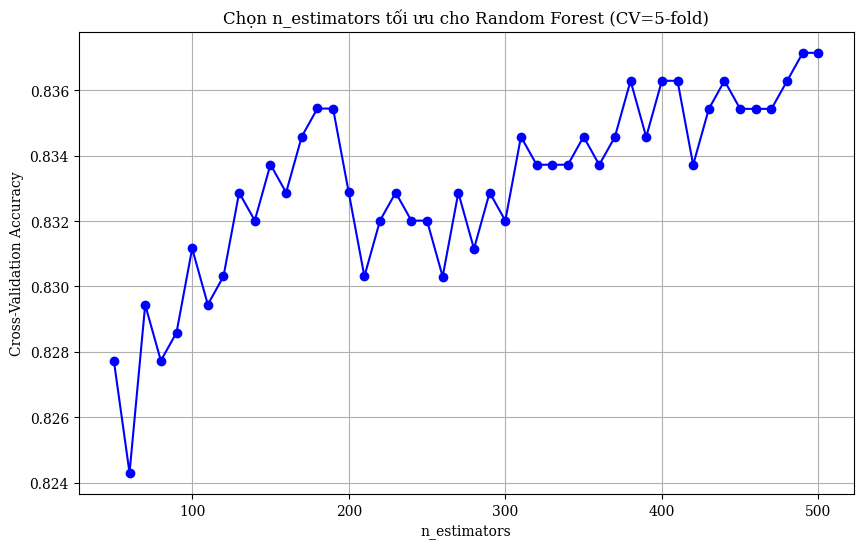


Độ chính xác Random Forest trên tập validation: 0.8586
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       182
           1       0.88      0.85      0.86       207

    accuracy                           0.86       389
   macro avg       0.86      0.86      0.86       389
weighted avg       0.86      0.86      0.86       389


Độ chính xác Random Forest trên tập test: 0.8406
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       182
           1       0.84      0.87      0.85       207

    accuracy                           0.84       389
   macro avg       0.84      0.84      0.84       389
weighted avg       0.84      0.84      0.84       389



In [83]:
rf_model, val_acc, best_params = evaluate_val_rf(
    X_train, y_train, X_val, y_val)

test_acc = evaluate_test_rf(rf_model, X_test, y_test)

### 3.2 RF on Feature Engineering Dataset

Tìm n_estimators tối ưu cho Random Forest...
n_estimators tối ưu (CV): 50


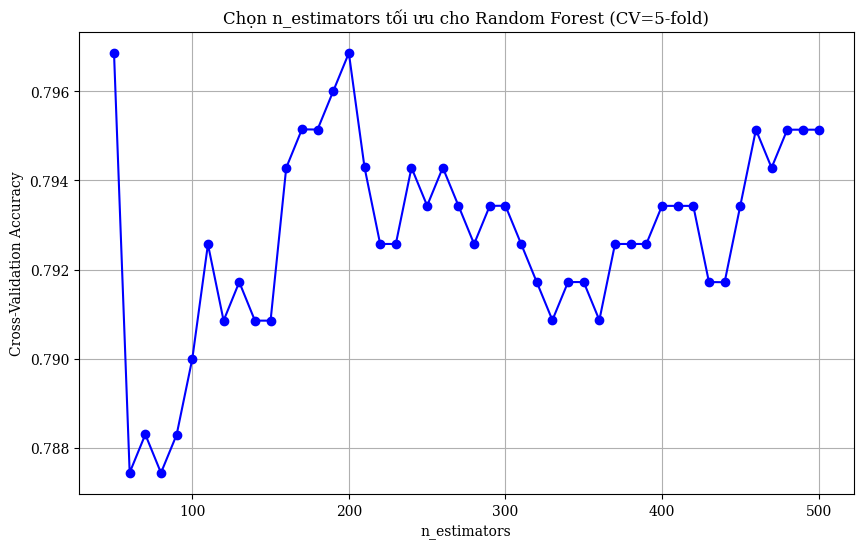


Độ chính xác Random Forest trên tập validation: 0.8432
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       182
           1       0.88      0.82      0.85       207

    accuracy                           0.84       389
   macro avg       0.84      0.85      0.84       389
weighted avg       0.85      0.84      0.84       389


Độ chính xác Random Forest trên tập test: 0.8175
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       182
           1       0.82      0.84      0.83       207

    accuracy                           0.82       389
   macro avg       0.82      0.82      0.82       389
weighted avg       0.82      0.82      0.82       389



In [84]:
rf_model, val_fe_acc, best_params = evaluate_val_rf(
    X_fe_train, y_fe_train, X_fe_val, y_fe_val)

test_fe_acc = evaluate_test_rf(rf_model, X_fe_test, y_fe_test)

### 3.3 RF on Original DT Dataset

Tìm n_estimators tối ưu cho Random Forest...
n_estimators tối ưu (CV): 180


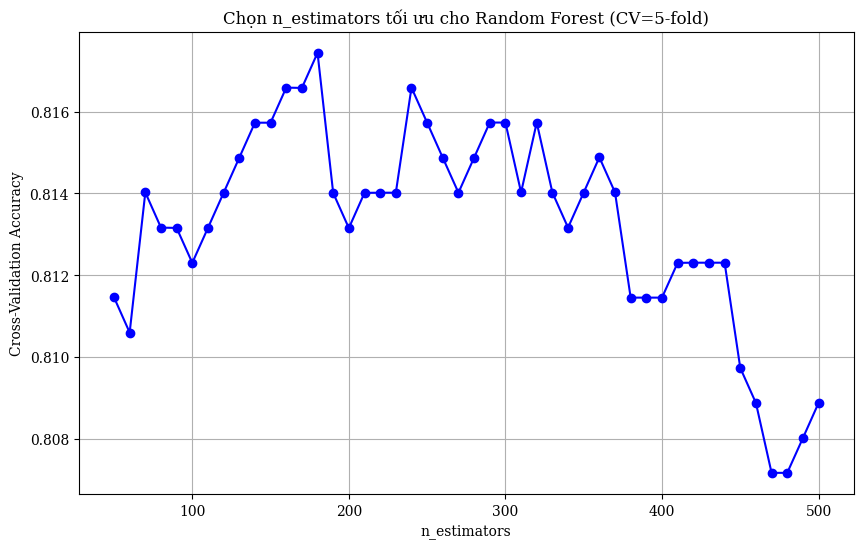


Độ chính xác Random Forest trên tập validation: 0.8535
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       182
           1       0.90      0.81      0.85       207

    accuracy                           0.85       389
   macro avg       0.86      0.86      0.85       389
weighted avg       0.86      0.85      0.85       389


Độ chính xác Random Forest trên tập test: 0.8252
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       182
           1       0.83      0.85      0.84       207

    accuracy                           0.83       389
   macro avg       0.83      0.82      0.82       389
weighted avg       0.83      0.83      0.82       389



In [85]:
rf_model, val_dt_acc, best_params = evaluate_val_rf(
    X_dt_train, y_dt_train, X_dt_val, y_dt_val)

test_dt_acc = evaluate_test_rf(rf_model, X_dt_test, y_dt_test)

### 3.4 RF on Feature Engineering DT Dataset

Tìm n_estimators tối ưu cho Random Forest...
n_estimators tối ưu (CV): 120


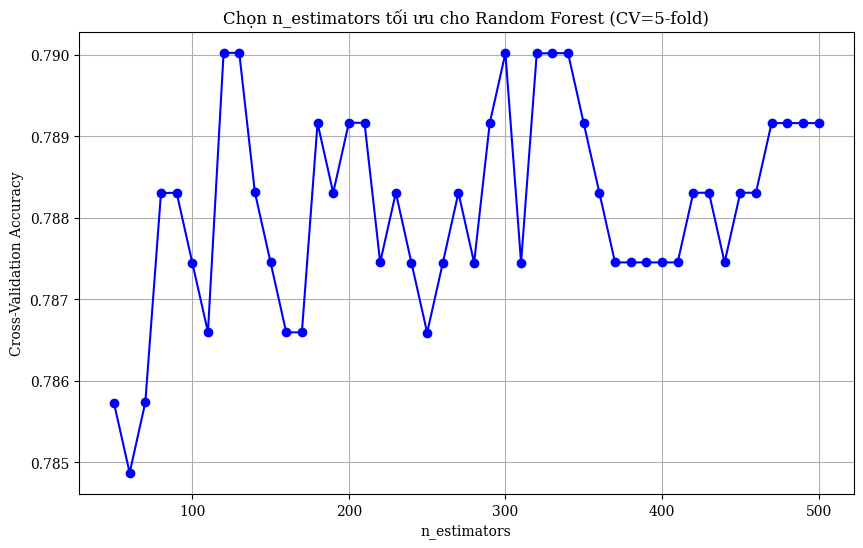


Độ chính xác Random Forest trên tập validation: 0.8329
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       182
           1       0.85      0.83      0.84       207

    accuracy                           0.83       389
   macro avg       0.83      0.83      0.83       389
weighted avg       0.83      0.83      0.83       389


Độ chính xác Random Forest trên tập test: 0.8123
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       182
           1       0.82      0.83      0.82       207

    accuracy                           0.81       389
   macro avg       0.81      0.81      0.81       389
weighted avg       0.81      0.81      0.81       389



In [86]:
rf_model, val_fe_dt_acc, best_params = evaluate_val_rf(
    X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val)

test_fe_dt_acc = evaluate_test_rf(rf_model, X_fe_dt_test, y_fe_dt_test)

### 3.5. RF (using RandomizedSearchCV) on Original Dataset

In [87]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import accuracy_score

def random_search(
    X_train, y_train, X_val, y_val,
    n_estimators_range=range(50, 501, 10),
    cv_splits=5, max_depth=range(1, 11, 1), min_samples_split=2, min_samples_leaf=1,
    max_features="sqrt", bootstrap=True, class_weight=None
):
    np.random.seed(SEED)
    random.seed(SEED)

    param_grid = {
        'n_estimators': list(n_estimators_range),
        'max_depth': list(max_depth)
    }

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=SEED)

    random_search = HalvingRandomSearchCV(
        RandomForestClassifier(random_state=SEED,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               bootstrap=bootstrap,
                               class_weight=class_weight,
                               max_features="sqrt",
                               n_jobs=-1),
        param_grid,
        n_candidates='exhaust',
        factor=50,
        random_state=SEED,
        cv=cv,
        verbose=0,
        n_jobs=-1,
    )
    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_
    best_params = random_search.best_params_

    val_pred = best_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)

    print(f"\nĐộ chính xác Random Forest trên tập validation (RandomizedSearchCV): {val_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, val_pred))
    return best_model, val_acc, best_params

def grid_search(
    X_train, y_train, X_val, y_val,
    n_estimators_range=range(50, 501, 10),
    cv_splits=5, max_depth=range(1, 11, 1), min_samples_split=2, min_samples_leaf=1,
    max_features="sqrt", bootstrap=True, class_weight=None
):
    np.random.seed(SEED)
    random.seed(SEED)

    param_grid = {
        'n_estimators': list(n_estimators_range),
        'max_depth': list(max_depth)
    }

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=SEED)

    grid_search = HalvingGridSearchCV(
        RandomForestClassifier(random_state=SEED,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               bootstrap=bootstrap,
                               class_weight=class_weight,
                               max_features="sqrt",
                               n_jobs=-1),
        param_grid,
        random_state=SEED,
        cv=cv,
        factor=50,
        verbose=0,
        n_jobs=-1,
    )
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    val_pred = best_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)

    print(f"\nĐộ chính xác Random Forest trên tập validation (GridSearchCV): {val_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, val_pred))
    return best_model, val_acc, best_params

In [88]:
rf_model, valgrid_acc, best_params = grid_search(
    X_train, y_train, X_val, y_val)

testgrid_acc = evaluate_test_rf(rf_model, X_test, y_test)


Độ chính xác Random Forest trên tập validation (GridSearchCV): 0.9075
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       182
           1       0.93      0.89      0.91       207

    accuracy                           0.91       389
   macro avg       0.91      0.91      0.91       389
weighted avg       0.91      0.91      0.91       389


Độ chính xác Random Forest trên tập test: 0.8920
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       182
           1       0.88      0.92      0.90       207

    accuracy                           0.89       389
   macro avg       0.89      0.89      0.89       389
weighted avg       0.89      0.89      0.89       389



In [89]:
rf_model, valrd_acc, best_params = random_search(
    X_train, y_train, X_val, y_val)

testrd_acc = evaluate_test_rf(rf_model, X_test, y_test)


Độ chính xác Random Forest trên tập validation (RandomizedSearchCV): 0.9023
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       182
           1       0.93      0.88      0.91       207

    accuracy                           0.90       389
   macro avg       0.90      0.90      0.90       389
weighted avg       0.90      0.90      0.90       389


Độ chính xác Random Forest trên tập test: 0.8843
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       182
           1       0.88      0.91      0.89       207

    accuracy                           0.88       389
   macro avg       0.89      0.88      0.88       389
weighted avg       0.88      0.88      0.88       389



### 3.6. RF (using RandomizedSearchCV & GridSearchCV) on FE dataset

In [90]:
rf_model, valgrid_fe_acc, best_params = grid_search(
    X_fe_train, y_fe_train, X_fe_val, y_fe_val)

testgrid_fe_acc = evaluate_test_rf(rf_model, X_fe_test, y_fe_test)


Độ chính xác Random Forest trên tập validation (GridSearchCV): 0.8355
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       182
           1       0.86      0.83      0.84       207

    accuracy                           0.84       389
   macro avg       0.83      0.84      0.84       389
weighted avg       0.84      0.84      0.84       389


Độ chính xác Random Forest trên tập test: 0.8149
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       182
           1       0.81      0.85      0.83       207

    accuracy                           0.81       389
   macro avg       0.82      0.81      0.81       389
weighted avg       0.82      0.81      0.81       389



In [91]:
rf_model, valrd_fe_acc, best_params = random_search(
    X_fe_train, y_fe_train, X_fe_val, y_fe_val)

testrd_fe_acc = evaluate_test_rf(rf_model, X_fe_test, y_fe_test)


Độ chính xác Random Forest trên tập validation (RandomizedSearchCV): 0.8329
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       182
           1       0.84      0.84      0.84       207

    accuracy                           0.83       389
   macro avg       0.83      0.83      0.83       389
weighted avg       0.83      0.83      0.83       389


Độ chính xác Random Forest trên tập test: 0.8175
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       182
           1       0.81      0.86      0.83       207

    accuracy                           0.82       389
   macro avg       0.82      0.81      0.82       389
weighted avg       0.82      0.82      0.82       389



### 3.7. RF (using RandomizedSearchCV & GridSearchCV) on Original DT dataset

In [92]:
rf_model, valgrid_dt_acc, best_params = grid_search(
    X_dt_train, y_dt_train, X_dt_val, y_dt_val)

testgrid_dt_acc = evaluate_test_rf(rf_model, X_dt_test, y_dt_test)


Độ chính xác Random Forest trên tập validation (GridSearchCV): 0.7969
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.68      0.76       182
           1       0.76      0.90      0.82       207

    accuracy                           0.80       389
   macro avg       0.81      0.79      0.79       389
weighted avg       0.81      0.80      0.79       389


Độ chính xác Random Forest trên tập test: 0.7661
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.62      0.71       182
           1       0.73      0.90      0.80       207

    accuracy                           0.77       389
   macro avg       0.78      0.76      0.76       389
weighted avg       0.78      0.77      0.76       389



In [93]:
rf_model, valrd_dt_acc, best_params = random_search(
    X_dt_train, y_dt_train, X_dt_val, y_dt_val)

testrd_dt_acc = evaluate_test_rf(rf_model, X_dt_test, y_dt_test)


Độ chính xác Random Forest trên tập validation (RandomizedSearchCV): 0.8843
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       182
           1       0.91      0.87      0.89       207

    accuracy                           0.88       389
   macro avg       0.88      0.89      0.88       389
weighted avg       0.89      0.88      0.88       389


Độ chính xác Random Forest trên tập test: 0.8638
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       182
           1       0.86      0.89      0.87       207

    accuracy                           0.86       389
   macro avg       0.86      0.86      0.86       389
weighted avg       0.86      0.86      0.86       389



### 3.8. RF (using RandomizedSearchV & GridSearchCV) on FE DT dataset

In [94]:
rf_model, valgrid_fe_dt_acc, best_params = grid_search(
    X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val)

testgrid_fe_dt_acc = evaluate_test_rf(rf_model, X_fe_dt_test, y_fe_dt_test)


Độ chính xác Random Forest trên tập validation (GridSearchCV): 0.8303
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       182
           1       0.85      0.83      0.84       207

    accuracy                           0.83       389
   macro avg       0.83      0.83      0.83       389
weighted avg       0.83      0.83      0.83       389


Độ chính xác Random Forest trên tập test: 0.8252
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       182
           1       0.84      0.84      0.84       207

    accuracy                           0.83       389
   macro avg       0.82      0.82      0.82       389
weighted avg       0.83      0.83      0.83       389



In [95]:
rf_model, valrd_fe_dt_acc, best_params = random_search(
    X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val)

testrd_fe_dt_acc = evaluate_test_rf(rf_model, X_fe_dt_test, y_fe_dt_test)


Độ chính xác Random Forest trên tập validation (RandomizedSearchCV): 0.8766
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       182
           1       0.88      0.88      0.88       207

    accuracy                           0.88       389
   macro avg       0.88      0.88      0.88       389
weighted avg       0.88      0.88      0.88       389


Độ chính xác Random Forest trên tập test: 0.8638
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       182
           1       0.87      0.88      0.87       207

    accuracy                           0.86       389
   macro avg       0.86      0.86      0.86       389
weighted avg       0.86      0.86      0.86       389



### Using Optuna for hyperparamater optimization

In [96]:
!pip install optuna

In [97]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=10)
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   random_state=SEED,
                                   n_jobs=-1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train the final model with the best hyperparameters
best_n_estimators = trial.params['n_estimators']
best_rf_model = RandomForestClassifier(n_estimators=best_n_estimators,
                                       random_state=SEED,
                                       n_jobs=-1,
                                       min_samples_split=2,
                                       min_samples_leaf=1,
                                       bootstrap=True,
                                       max_features="sqrt",
                                       max_depth=5)
best_rf_model.fit(X_train, y_train)

# Evaluate on the validation set
val_pred = best_rf_model.predict(X_val)
val_acc_optuna = accuracy_score(y_val, val_pred)
print(f"\nĐộ chính xác Random Forest trên tập validation (Optuna): {val_acc_optuna:.4f}")
print("Classification Report:")
print(classification_report(y_val, val_pred))

# Evaluate on the test set
test_acc_optuna = evaluate_test_rf(best_rf_model, X_test, y_test)

[I 2025-10-01 15:13:27,123] A new study created in memory with name: no-name-f6df9944-1f5b-474e-83f6-e37b083037d3
[I 2025-10-01 15:13:28,104] Trial 0 finished with value: 0.8817358130662853 and parameters: {'n_estimators': 120}. Best is trial 0 with value: 0.8817358130662853.
[I 2025-10-01 15:13:31,726] Trial 1 finished with value: 0.8825978504090092 and parameters: {'n_estimators': 350}. Best is trial 1 with value: 0.8825978504090092.
[I 2025-10-01 15:13:34,906] Trial 2 finished with value: 0.8825978504090092 and parameters: {'n_estimators': 270}. Best is trial 1 with value: 0.8825978504090092.
[I 2025-10-01 15:13:42,159] Trial 3 finished with value: 0.8817394813102968 and parameters: {'n_estimators': 500}. Best is trial 1 with value: 0.8825978504090092.
[I 2025-10-01 15:13:48,289] Trial 4 finished with value: 0.8843072521184109 and parameters: {'n_estimators': 420}. Best is trial 4 with value: 0.8843072521184109.
[I 2025-10-01 15:13:53,112] Trial 5 finished with value: 0.884310920362

Best trial:
  Value: 0.8860203220718242
  Params: 
    n_estimators: 450

Độ chính xác Random Forest trên tập validation (Optuna): 0.8586
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       182
           1       0.88      0.85      0.86       207

    accuracy                           0.86       389
   macro avg       0.86      0.86      0.86       389
weighted avg       0.86      0.86      0.86       389


Độ chính xác Random Forest trên tập test: 0.8406
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       182
           1       0.84      0.87      0.85       207

    accuracy                           0.84       389
   macro avg       0.84      0.84      0.84       389
weighted avg       0.84      0.84      0.84       389



In [98]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=10)
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   random_state=SEED,
                                   n_jobs=-1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(model, X_fe_train, y_fe_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train the final model with the best hyperparameters
best_n_estimators = trial.params['n_estimators']
best_rf_model = RandomForestClassifier(n_estimators=best_n_estimators,
                                       random_state=SEED,
                                       n_jobs=-1,
                                       min_samples_split=2,
                                       min_samples_leaf=1,
                                       bootstrap=True,
                                       max_features="sqrt",
                                       max_depth=5)
best_rf_model.fit(X_fe_train, y_fe_train)

# Evaluate on the validation set
val_pred = best_rf_model.predict(X_fe_val)
val_acc_optuna = accuracy_score(y_fe_val, val_pred)
print(f"\nĐộ chính xác Random Forest trên tập validation (Optuna): {val_acc_optuna:.4f}")
print("Classification Report:")
print(classification_report(y_val, val_pred))

# Evaluate on the test set
test_acc_optuna = evaluate_test_rf(best_rf_model, X_fe_test, y_fe_test)

[I 2025-10-01 15:18:57,198] A new study created in memory with name: no-name-be49da97-2052-4359-93bd-4e977b9cd934
[I 2025-10-01 15:18:59,118] Trial 0 finished with value: 0.8466160448993068 and parameters: {'n_estimators': 240}. Best is trial 0 with value: 0.8466160448993068.
[I 2025-10-01 15:19:04,851] Trial 1 finished with value: 0.8371923260335278 and parameters: {'n_estimators': 480}. Best is trial 0 with value: 0.8466160448993068.
[I 2025-10-01 15:19:08,299] Trial 2 finished with value: 0.8466160448993068 and parameters: {'n_estimators': 240}. Best is trial 0 with value: 0.8466160448993068.
[I 2025-10-01 15:19:11,102] Trial 3 finished with value: 0.8448993067018818 and parameters: {'n_estimators': 200}. Best is trial 0 with value: 0.8466160448993068.
[I 2025-10-01 15:19:13,636] Trial 4 finished with value: 0.8474707457540076 and parameters: {'n_estimators': 180}. Best is trial 4 with value: 0.8474707457540076.
[I 2025-10-01 15:19:18,569] Trial 5 finished with value: 0.844899306701

Best trial:
  Value: 0.8474744139980193
  Params: 
    n_estimators: 230

Độ chính xác Random Forest trên tập validation (Optuna): 0.8483
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       182
           1       0.88      0.83      0.85       207

    accuracy                           0.85       389
   macro avg       0.85      0.85      0.85       389
weighted avg       0.85      0.85      0.85       389


Độ chính xác Random Forest trên tập test: 0.8303
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       182
           1       0.83      0.86      0.84       207

    accuracy                           0.83       389
   macro avg       0.83      0.83      0.83       389
weighted avg       0.83      0.83      0.83       389



In [99]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=10)
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   random_state=SEED,
                                   n_jobs=-1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(model, X_dt_train, y_dt_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train the final model with the best hyperparameters
best_n_estimators = trial.params['n_estimators']
best_rf_model = RandomForestClassifier(n_estimators=best_n_estimators,
                                       random_state=SEED,
                                       n_jobs=-1,
                                       min_samples_split=2,
                                       min_samples_leaf=1,
                                       bootstrap=True,
                                       max_features="sqrt",
                                       max_depth=5)
best_rf_model.fit(X_dt_train, y_dt_train)

# Evaluate on the validation set
val_pred = best_rf_model.predict(X_dt_val)
val_acc_optuna = accuracy_score(y_dt_val, val_pred)
print(f"\nĐộ chính xác Random Forest trên tập validation (Optuna): {val_acc_optuna:.4f}")
print("Classification Report:")
print(classification_report(y_val, val_pred))

# Evaluate on the test set
test_acc_optuna = evaluate_test_rf(best_rf_model, X_dt_test, y_dt_test)

[I 2025-10-01 15:22:15,610] A new study created in memory with name: no-name-3b4ba082-d201-42cf-adce-bcbb0dd8e035
[I 2025-10-01 15:22:18,548] Trial 0 finished with value: 0.8680129122189207 and parameters: {'n_estimators': 390}. Best is trial 0 with value: 0.8680129122189207.
[I 2025-10-01 15:22:19,068] Trial 1 finished with value: 0.8662998422655075 and parameters: {'n_estimators': 60}. Best is trial 0 with value: 0.8680129122189207.
[I 2025-10-01 15:22:20,547] Trial 2 finished with value: 0.8705843512710466 and parameters: {'n_estimators': 190}. Best is trial 2 with value: 0.8705843512710466.
[I 2025-10-01 15:22:22,892] Trial 3 finished with value: 0.8705916877590697 and parameters: {'n_estimators': 310}. Best is trial 3 with value: 0.8705916877590697.
[I 2025-10-01 15:22:25,493] Trial 4 finished with value: 0.874021495909908 and parameters: {'n_estimators': 250}. Best is trial 4 with value: 0.874021495909908.
[I 2025-10-01 15:22:26,464] Trial 5 finished with value: 0.868012912218920

Best trial:
  Value: 0.8748761967646088
  Params: 
    n_estimators: 240

Độ chính xác Random Forest trên tập validation (Optuna): 0.8509
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       182
           1       0.90      0.81      0.85       207

    accuracy                           0.85       389
   macro avg       0.85      0.85      0.85       389
weighted avg       0.86      0.85      0.85       389


Độ chính xác Random Forest trên tập test: 0.8201
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       182
           1       0.82      0.85      0.83       207

    accuracy                           0.82       389
   macro avg       0.82      0.82      0.82       389
weighted avg       0.82      0.82      0.82       389



### 3.9. Stacked Ensemble Learning on Original DT

In [100]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

estimators = [
    ('ada', AdaBoostClassifier(DecisionTreeClassifier(random_state=SEED),
                               n_estimators=100,
                               learning_rate=0.1,
                               random_state=SEED)),
    ('rf', RandomForestClassifier(n_estimators=50,
                               random_state=SEED,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               bootstrap=True,
                               class_weight=None,
                               max_depth=5,
                               n_jobs=-1))
]

final_estimator = RandomForestClassifier(n_estimators=100,
                                         n_jobs=-1,
                                         min_samples_split=2,
                                         min_samples_leaf=1,
                                         bootstrap=True,
                                         max_features="sqrt",
                                         max_depth=5,
                                         random_state=SEED)
# final_estimator = LogisticRegression(max_iter=2000)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

clf = StackingClassifier(estimators=estimators,
                         final_estimator=final_estimator,
                         cv=cv,
                         passthrough=False)

clf.fit(X_train, y_train)

val_pred = clf.predict(X_test)
val_acc = accuracy_score(y_test, val_pred)

print("Validation Accuracy:", val_acc)

Validation Accuracy: 0.8508997429305912


### 3.10. Stacked Ensemble Learning on FE dataset

In [101]:
clf.fit(X_fe_train, y_fe_train)

val_pred = clf.predict(X_fe_test)
val_acc = accuracy_score(y_fe_test, val_pred)

print("Validation Accuracy:", val_acc)

Validation Accuracy: 0.8637532133676092


In [102]:
#clf.fit(X_dt_train, y_dt_train).score(X_dt_test, y_dt_test)

clf.fit(X_dt_train, y_dt_train)

val_pred = clf.predict(X_dt_test)
val_acc = accuracy_score(y_dt_test, val_pred)

print("Validation Accuracy:", val_acc)

Validation Accuracy: 0.8431876606683805


In [103]:
#clf.fit(X_fe_dt_train, y_fe_dt_train).score(X_fe_dt_test, y_fe_dt_test)

clf.fit(X_fe_dt_train, y_fe_dt_train)

val_pred = clf.predict(X_fe_dt_test)
val_acc = accuracy_score(y_fe_dt_test, val_pred)

print("Validation Accuracy:", val_acc)

Validation Accuracy: 0.87146529562982


### 3.11. Another implementation

In [104]:
# --- imports ---
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import numpy as np

# (tuỳ chọn) XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception as _:
    HAS_XGB = False
    print("[Info] xgboost chưa được cài; sẽ bỏ qua candidate XGB.")

SEED = 42

# --- CV ngoài để so sánh các ứng viên (trên X_train) ---
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# --- RF meta-model ---
final_estimator = RandomForestClassifier(
    n_estimators=50, n_jobs=-1, min_samples_split=2, min_samples_leaf=1,
    bootstrap=True, max_features="sqrt", random_state=SEED
)

# --- RF ở base (đi kèm từng candidate) ---
rf_base = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, random_state=SEED,
    min_samples_split=2, min_samples_leaf=1, bootstrap=True
)

# Số lớp để tinh chỉnh n_clusters cho KMeans
n_classes = np.unique(y_train).size
kmeans_k = max(2, min(8, n_classes * 2))  # nhẹ nhàng, tránh quá lớn

# --- mini-stack (KNN, DT, NB) làm 1 candidate riêng ---
mini_stack = StackingClassifier(
    estimators=[
        ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier())),
        ('dt',  DecisionTreeClassifier(random_state=SEED)),
        ('nb',  GaussianNB()),
    ],
    final_estimator=LogisticRegression(max_iter=2000, random_state=SEED),
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# --- xây dựng các candidate đúng yêu cầu ---
candidates = {
    # 1) Naive Bayes
    "NB": GaussianNB(),

    # 2) KNN (chuẩn hoá trước)
    "KNN": make_pipeline(StandardScaler(), KNeighborsClassifier()),

    # 3) KMeans (dùng như bộ biến đổi sinh đặc trưng khoảng cách cụm + LR phân loại)
    #    Pipeline: Scale -> KMeans.transform -> LR
    "KMeans": make_pipeline(
        StandardScaler(),
        KMeans(n_clusters=kmeans_k, random_state=SEED, n_init="auto"),
        LogisticRegression(max_iter=2000, random_state=SEED)
    ),

    # 4) (KNN, DT, NB) gói trong một mini-stacking
    "(KNN,DT,NB)": mini_stack,

    # 5) AdaBoost (base = stump hoặc DT nhỏ)
    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, random_state=SEED),
        n_estimators=100, random_state=SEED
    ),

    # 6) Gradient Boosting
    "GB": GradientBoostingClassifier(random_state=SEED),
}

# 7) XGBoost (nếu có)
if HAS_XGB:
    candidates["XGB"] = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        tree_method="hist",      # nhanh, ổn
        random_state=SEED,
        n_jobs=-1
        # Không set objective để wrapper tự suy luận binary/multiclass
    )

In [105]:
results = []
best_model = None
best_name = None
best_cv = -np.inf

for name, est in candidates.items():
    base = [
        ('rf_base', rf_base),
        (name, est),
    ]
    clf = StackingClassifier(
        estimators=base,
        final_estimator=final_estimator,
        cv=5,            # OOF cho tầng meta
        n_jobs=-1,
        passthrough=True
    )
    # Đánh giá CV ngoài trên X_train
    scores = cross_val_score(clf, X_train, y_train, cv=outer_cv, scoring="accuracy", n_jobs=-1)
    mean_acc = scores.mean()
    results.append((name, mean_acc))
    if mean_acc > best_cv:
        best_cv = mean_acc
        best_name = name
        best_model = clf

# Fit mô hình tốt nhất và đo test accuracy
best_model.fit(X_train, y_train)
val_pred = best_model.predict(X_test)
val_acc = accuracy_score(y_test, val_pred)

print("=== CV mean accuracies (Original dataset, train) ===")
for name, s in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{name:12s}: {s:.4f}")
print(f"\nBest (CV): {best_name} -> {best_cv:.4f}")
print(f"Test accuracy of best model: {val_acc:.4f}")

# Giữ template quen thuộc
print("best_model =", best_model)

=== CV mean accuracies (Original dataset, train) ===
KNN         : 0.8920
(KNN,DT,NB) : 0.8877
XGB         : 0.8860
NB          : 0.8834
AdaBoost    : 0.8826
KMeans      : 0.8817
GB          : 0.8783

Best (CV): KNN -> 0.8920
Test accuracy of best model: 0.8946
best_model = StackingClassifier(cv=5,
                   estimators=[('rf_base',
                                RandomForestClassifier(n_jobs=-1,
                                                       random_state=42)),
                               ('KNN',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier())]))],
                   final_estimator=RandomForestClassifier(n_estimators=50,
                                                          n_jobs=-1,
                                                

In [106]:
results = []
best_model = None
best_name = None
best_cv = -np.inf

for name, est in candidates.items():
    base = [
        ('rf_base', rf_base),
        (name, est),
    ]
    clf = StackingClassifier(
        estimators=base,
        final_estimator=final_estimator,
        cv=5,            # OOF cho tầng meta
        n_jobs=-1,
        passthrough=True
    )
    # Đánh giá CV ngoài trên X_train
    scores = cross_val_score(clf, X_fe_train, y_fe_train, cv=outer_cv, scoring="accuracy", n_jobs=-1)
    mean_acc = scores.mean()
    results.append((name, mean_acc))
    if mean_acc > best_cv:
        best_cv = mean_acc
        best_name = name
        best_model = clf

# Fit mô hình tốt nhất và đo test accuracy
best_model.fit(X_fe_train, y_fe_train)
val_pred = best_model.predict(X_fe_test)
val_acc = accuracy_score(y_fe_test, val_pred)

print("=== CV mean accuracies (FE dataset, train) ===")
for name, s in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{name:12s}: {s:.4f}")
print(f"\nBest (CV): {best_name} -> {best_cv:.4f}")
print(f"Test accuracy of best model: {val_acc:.4f}")

# Giữ template quen thuộc
print("best_model =", best_model)

=== CV mean accuracies (FE dataset, train) ===
(KNN,DT,NB) : 0.8569
NB          : 0.8535
AdaBoost    : 0.8509
KMeans      : 0.8500
GB          : 0.8483
KNN         : 0.8466
XGB         : 0.8432

Best (CV): (KNN,DT,NB) -> 0.8569
Test accuracy of best model: 0.8766
best_model = StackingClassifier(cv=5,
                   estimators=[('rf_base',
                                RandomForestClassifier(n_jobs=-1,
                                                       random_state=42)),
                               ('(KNN,DT,NB)',
                                StackingClassifier(cv=5,
                                                   estimators=[('knn',
                                                                Pipeline(steps=[('standardscaler',
                                                                                 StandardScaler()),
                                                                                ('kneighborsclassifier',
                                    

In [107]:
results = []
best_model = None
best_name = None
best_cv = -np.inf

for name, est in candidates.items():
    base = [
        ('rf_base', rf_base),
        (name, est),
    ]
    clf = StackingClassifier(
        estimators=base,
        final_estimator=final_estimator,
        cv=5,            # OOF cho tầng meta
        n_jobs=-1,
        passthrough=True
    )
    # Đánh giá CV ngoài trên X_train
    scores = cross_val_score(clf, X_dt_train, y_dt_train, cv=outer_cv, scoring="accuracy", n_jobs=-1)
    mean_acc = scores.mean()
    results.append((name, mean_acc))
    if mean_acc > best_cv:
        best_cv = mean_acc
        best_name = name
        best_model = clf

# Fit mô hình tốt nhất và đo test accuracy
best_model.fit(X_dt_train, y_dt_train)
val_pred = best_model.predict(X_dt_test)
val_acc = accuracy_score(y_dt_test, val_pred)

print("=== CV mean accuracies (FE dataset, train) ===")
for name, s in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{name:12s}: {s:.4f}")
print(f"\nBest (CV): {best_name} -> {best_cv:.4f}")
print(f"Test accuracy of best model: {val_acc:.4f}")

# Giữ template quen thuộc
print("best_model =", best_model)

=== CV mean accuracies (FE dataset, train) ===
NB          : 0.8749
KMeans      : 0.8714
XGB         : 0.8714
GB          : 0.8680
(KNN,DT,NB) : 0.8672
KNN         : 0.8663
AdaBoost    : 0.8560

Best (CV): NB -> 0.8749
Test accuracy of best model: 0.8895
best_model = StackingClassifier(cv=5,
                   estimators=[('rf_base',
                                RandomForestClassifier(n_jobs=-1,
                                                       random_state=42)),
                               ('NB', GaussianNB())],
                   final_estimator=RandomForestClassifier(n_estimators=50,
                                                          n_jobs=-1,
                                                          random_state=42),
                   n_jobs=-1, passthrough=True)


In [108]:
results = []
best_model = None
best_name = None
best_cv = -np.inf

for name, est in candidates.items():
    base = [
        ('rf_base', rf_base),
        (name, est),
    ]
    clf = StackingClassifier(
        estimators=base,
        final_estimator=final_estimator,
        cv=5,            # OOF cho tầng meta
        n_jobs=-1,
        passthrough=True
    )
    # Đánh giá CV ngoài trên X_train
    scores = cross_val_score(clf, X_fe_dt_train, y_fe_dt_train, cv=outer_cv, scoring="accuracy", n_jobs=-1)
    mean_acc = scores.mean()
    results.append((name, mean_acc))
    if mean_acc > best_cv:
        best_cv = mean_acc
        best_name = name
        best_model = clf

# Fit mô hình tốt nhất và đo test accuracy
best_model.fit(X_fe_dt_train, y_fe_dt_train)
val_pred = best_model.predict(X_fe_dt_test)
val_acc = accuracy_score(y_fe_dt_test, val_pred)

print("=== CV mean accuracies (FE dataset, train) ===")
for name, s in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{name:12s}: {s:.4f}")
print(f"\nBest (CV): {best_name} -> {best_cv:.4f}")
print(f"Test accuracy of best model: {val_acc:.4f}")

# Giữ template quen thuộc
print("best_model =", best_model)

=== CV mean accuracies (FE dataset, train) ===
KNN         : 0.8423
NB          : 0.8397
XGB         : 0.8355
GB          : 0.8346
KMeans      : 0.8346
AdaBoost    : 0.8337
(KNN,DT,NB) : 0.8286

Best (CV): KNN -> 0.8423
Test accuracy of best model: 0.8663
best_model = StackingClassifier(cv=5,
                   estimators=[('rf_base',
                                RandomForestClassifier(n_jobs=-1,
                                                       random_state=42)),
                               ('KNN',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier())]))],
                   final_estimator=RandomForestClassifier(n_estimators=50,
                                                          n_jobs=-1,
                                                      

## Gradient Boosting

In [109]:
# ==== 1) Tìm hyperparameters tối ưu bằng Cross-Validation ====
def find_optimal_gb(
    X_train, y_train,
    n_estimators_range=range(50, 501, 10),
    cv_splits=5
):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=SEED)
    scores = []

    for n in n_estimators_range:
        gb = GradientBoostingClassifier(
            n_estimators=n, learning_rate=0.1,
            max_depth=5, subsample=1.0, random_state=SEED
        )
        cv_score = cross_val_score(
            gb, X_train, y_train,
            cv=cv, scoring='accuracy', n_jobs=-1
        )
        scores.append(cv_score.mean())

    plt.figure(figsize=(10, 6))
    plt.plot(list(n_estimators_range), scores, 'bo-')
    plt.title(f'Chọn n_estimators tối ưu cho Gradient Boosting (CV={cv_splits}-fold)')
    plt.xlabel('n_estimators')
    plt.ylabel('Cross-Validation Accuracy')
    plt.grid(True)
    plt.show()

    best_n = list(n_estimators_range)[int(np.argmax(scores))]
    print(f'n_estimators tối ưu (CV): {best_n}')

    best_model = GradientBoostingClassifier(
        n_estimators=best_n,
        learning_rate=0.1,
        max_depth=5,
        subsample=1.0,
        random_state=SEED
    )
    best_model.fit(X_train, y_train)
    return best_model, best_n, max(scores)

def evaluate_val_gb(X_train, y_train, X_val, y_val,
                    n_estimators_range=range(50, 501, 10),
                    cv_splits=5):
    print('Tìm n_estimators tối ưu cho Gradient Boosting...')
    gb_model, best_n, cv_acc = find_optimal_gb(
        X_train, y_train,
        n_estimators_range=n_estimators_range,
        cv_splits=cv_splits
    )

    val_pred = gb_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f'\nĐộ chính xác GB trên tập validation: {val_acc:.4f}')
    print('Classification Report:')
    print(classification_report(y_val, val_pred))
    return gb_model, val_acc, {'n_estimators': best_n}

def evaluate_test_gb(gb_model, X_test, y_test):
    test_pred = gb_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print(f'\nĐộ chính xác GB trên tập test: {test_acc:.4f}')
    print('Classification Report:')
    print(classification_report(y_test, test_pred))
    return test_acc

Tìm n_estimators tối ưu cho Gradient Boosting...


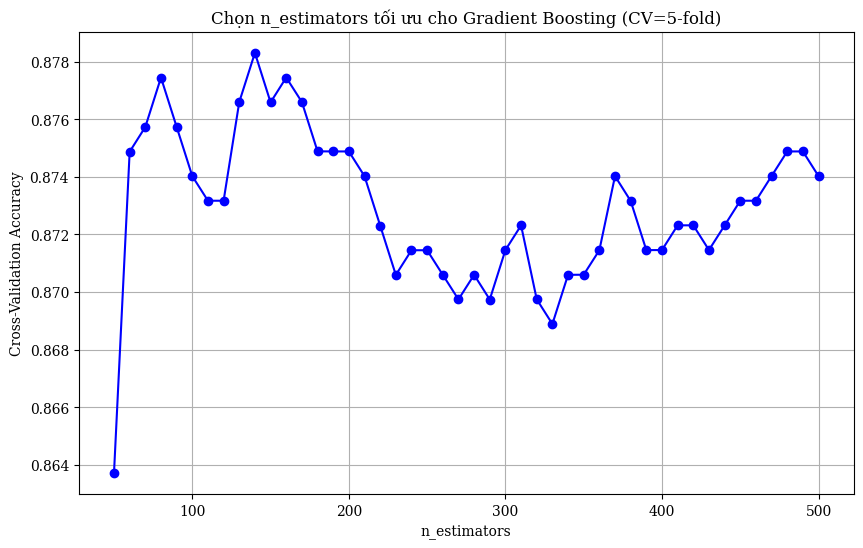

n_estimators tối ưu (CV): 140

Độ chính xác GB trên tập validation: 0.8766
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88       182
           1       0.93      0.84      0.88       207

    accuracy                           0.88       389
   macro avg       0.88      0.88      0.88       389
weighted avg       0.88      0.88      0.88       389


Độ chính xác GB trên tập test: 0.8817
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       182
           1       0.89      0.89      0.89       207

    accuracy                           0.88       389
   macro avg       0.88      0.88      0.88       389
weighted avg       0.88      0.88      0.88       389



In [110]:
# 1) Tìm & train model tốt nhất trên X_train
gb_model, val_acc, best_params = evaluate_val_gb(
    X_train, y_train, X_val, y_val
)

# 2) Đánh giá test
test_acc = evaluate_test_gb(gb_model, X_test, y_test)

In [111]:
%pip install optuna

In [112]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier  # Changed from RandomForestClassifier
import numpy as np

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5, log=True)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    model = GradientBoostingClassifier(
            n_estimators=n_estimators, learning_rate=learning_rate,
            max_depth=max_depth, subsample=subsample, random_state=SEED,
        )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_n_estimators = trial.params['n_estimators']
best_learning_rate = trial.params['learning_rate']
best_max_depth = trial.params['max_depth']
best_subsample = trial.params['subsample']

# Train the final model with the best hyperparameters
best_gb_model = GradientBoostingClassifier(
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    max_depth=best_max_depth, subsample=best_subsample, random_state=SEED
) # Changed from best_rf_model and added GB params
best_gb_model.fit(X_train, y_train) # Changed model name

# Evaluate on the validation set
val_pred = best_gb_model.predict(X_val) # Changed model name
val_acc_optuna = accuracy_score(y_val, val_pred)
print(f"\nĐộ chính xác Gradient Boosting trên tập validation (Optuna): {val_acc_optuna:.4f}") # Changed model name
print("Classification Report:")
print(classification_report(y_val, val_pred))

# Evaluate on the test set
test_acc_optuna = evaluate_test_gb(best_gb_model, X_test, y_test) # Changed model name

[I 2025-10-01 15:31:29,972] A new study created in memory with name: no-name-11e2b9d2-1879-40ef-8498-984f7ae995eb
[I 2025-10-01 15:31:35,024] Trial 0 finished with value: 0.8765892667180222 and parameters: {'n_estimators': 320, 'learning_rate': 0.09298388229857962, 'max_depth': 5, 'subsample': 0.6758049241473472}. Best is trial 0 with value: 0.8765892667180222.
[I 2025-10-01 15:31:38,291] Trial 1 finished with value: 0.7780162136385312 and parameters: {'n_estimators': 300, 'learning_rate': 0.19192652018768475, 'max_depth': 1, 'subsample': 0.9353729124993894}. Best is trial 0 with value: 0.8765892667180222.
[I 2025-10-01 15:31:39,741] Trial 2 finished with value: 0.8662998422655075 and parameters: {'n_estimators': 80, 'learning_rate': 0.12886884758965286, 'max_depth': 5, 'subsample': 0.5039209895282727}. Best is trial 0 with value: 0.8765892667180222.
[I 2025-10-01 15:31:47,905] Trial 3 finished with value: 0.8560397637650856 and parameters: {'n_estimators': 470, 'learning_rate': 0.4995

Best trial:
  Value: 0.8842999156303877
  Params: 
    n_estimators: 160
    learning_rate: 0.03432549509301471
    max_depth: 9
    subsample: 0.8357676307560062

Độ chính xác Gradient Boosting trên tập validation (Optuna): 0.8895
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       182
           1       0.93      0.86      0.89       207

    accuracy                           0.89       389
   macro avg       0.89      0.89      0.89       389
weighted avg       0.89      0.89      0.89       389


Độ chính xác GB trên tập test: 0.8715
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       182
           1       0.87      0.90      0.88       207

    accuracy                           0.87       389
   macro avg       0.87      0.87      0.87       389
weighted avg       0.87      0.87      0.87       389



## XGBoost

In [113]:
# ==== 1) Tìm hyperparameters tối ưu bằng Cross-Validation ====
def find_optimal_xgb(
    X_train, y_train,
    n_estimators_range=range(50, 501, 10),
    cv_splits=5,
    learning_rate=0.1,
    max_depth=5,
    subsample=1.0,
    use_gpu=False
):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=SEED)
    scores = []

    n_classes = len(np.unique(y_train))
    objective = 'binary:logistic' if n_classes == 2 else 'multi:softprob'
    eval_metric = 'logloss' if n_classes == 2 else 'mlogloss'

    for n in n_estimators_range:
        xgb = XGBClassifier(
            n_estimators=n, learning_rate=learning_rate, max_depth=max_depth, subsample=subsample,
            objective=objective, eval_metric=eval_metric, random_state=SEED, n_jobs=-1,
            tree_method='gpu_hist' if use_gpu else 'hist', verbosity=0
        )
        cv_score = cross_val_score(
            xgb, X_train, y_train,
            cv=cv, scoring='accuracy', n_jobs=-1
        )
        scores.append(cv_score.mean())

    plt.figure(figsize=(10, 6))
    plt.plot(list(n_estimators_range), scores, 'bo-')
    plt.title(f'Chọn n_estimators tối ưu cho XGBoost (CV={cv_splits}-fold)')
    plt.xlabel('n_estimators')
    plt.ylabel('Cross-Validation Accuracy')
    plt.grid(True)
    plt.show()

    best_n = list(n_estimators_range)[int(np.argmax(scores))]
    print(f'n_estimators tối ưu (CV): {best_n}')

    best_model = XGBClassifier(
        n_estimators=best_n, learning_rate=learning_rate, max_depth=max_depth, subsample=subsample,
        objective=objective, eval_metric=eval_metric, random_state=SEED, n_jobs=-1,
        tree_method='gpu_hist' if use_gpu else 'hist', verbosity=0
    )
    best_model.fit(X_train, y_train)
    return best_model, best_n, max(scores)

# ==== 2) Đánh giá trên tập validation ====
def evaluate_val_xgb(X_train, y_train, X_val, y_val,
                     n_estimators_range=range(50, 501, 10), cv_splits=5,
                     learning_rate=0.1, max_depth=5, subsample=1.0,
                     colsample_bytree=1.0, use_gpu=False):
    print('Tìm n_estimators tối ưu cho XGBoost...')
    xgb_model, best_n, cv_acc = find_optimal_xgb(
        X_train, y_train, n_estimators_range=n_estimators_range,
        cv_splits=cv_splits, learning_rate=learning_rate,
        max_depth=max_depth, subsample=subsample, use_gpu=use_gpu
    )

    val_pred = xgb_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f'\nĐộ chính xác XGBoost trên tập validation: {val_acc:.4f}')
    print('Classification Report:')
    print(classification_report(y_val, val_pred))
    return xgb_model, val_acc, {'n_estimators': best_n}

# ==== 3) Đánh giá trên tập test ====
def evaluate_test_xgb(xgb_model, X_test, y_test):
    test_pred = xgb_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print(f'\nĐộ chính xác XGBoost trên tập test: {test_acc:.4f}')
    print('Classification Report:')
    print(classification_report(y_test, test_pred))
    return test_acc

Tìm n_estimators tối ưu cho XGBoost...


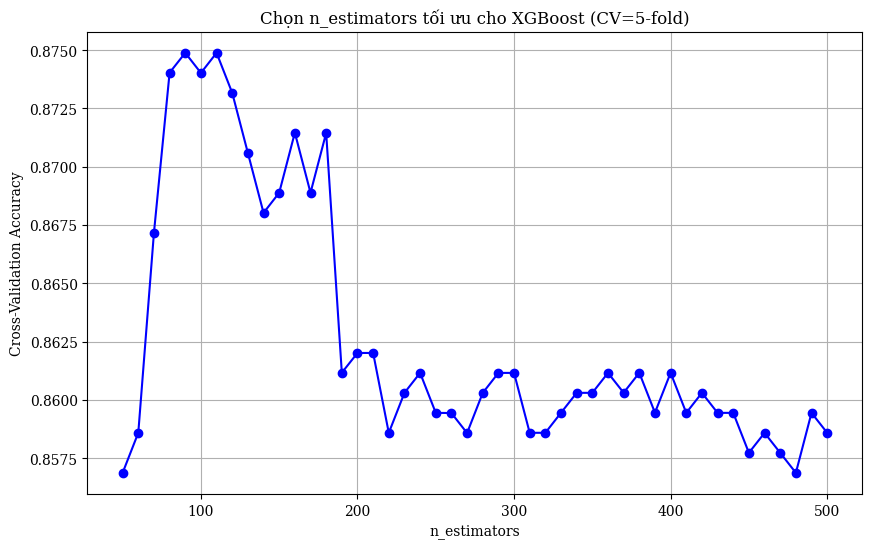

n_estimators tối ưu (CV): 90

Độ chính xác XGBoost trên tập validation: 0.8843
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       182
           1       0.93      0.85      0.89       207

    accuracy                           0.88       389
   macro avg       0.89      0.89      0.88       389
weighted avg       0.89      0.88      0.88       389


Độ chính xác XGBoost trên tập test: 0.8509
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       182
           1       0.85      0.88      0.86       207

    accuracy                           0.85       389
   macro avg       0.85      0.85      0.85       389
weighted avg       0.85      0.85      0.85       389



In [114]:
# 1) Tìm & train model tốt nhất trên X_train
xgb_model, val_acc, best_params = evaluate_val_xgb(
    X_train, y_train, X_val, y_val
)

# 2) Đánh giá test
test_acc = evaluate_test_xgb(xgb_model, X_test, y_test)

Tìm n_estimators tối ưu cho XGBoost...


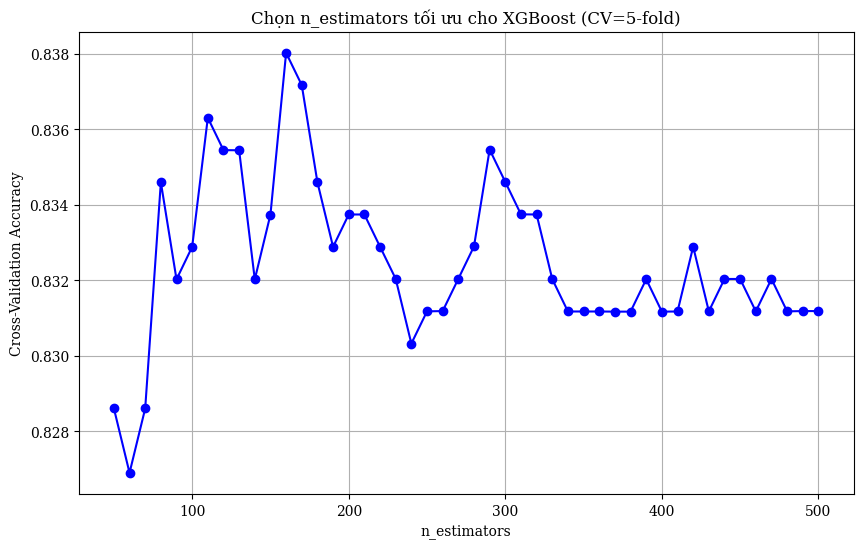

n_estimators tối ưu (CV): 160

Độ chính xác XGBoost trên tập validation: 0.8766
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       182
           1       0.90      0.87      0.88       207

    accuracy                           0.88       389
   macro avg       0.88      0.88      0.88       389
weighted avg       0.88      0.88      0.88       389


Độ chính xác XGBoost trên tập test: 0.8586
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       182
           1       0.86      0.87      0.87       207

    accuracy                           0.86       389
   macro avg       0.86      0.86      0.86       389
weighted avg       0.86      0.86      0.86       389



In [115]:
# 1) Tìm & train model tốt nhất trên X_train
xgb_model, val_fe_acc, best_params = evaluate_val_xgb(
    X_fe_train, y_fe_train, X_fe_val, y_fe_val
)

# 2) Đánh giá test
test_fe_acc = evaluate_test_xgb(xgb_model, X_fe_test, y_fe_test)

Tìm n_estimators tối ưu cho XGBoost...


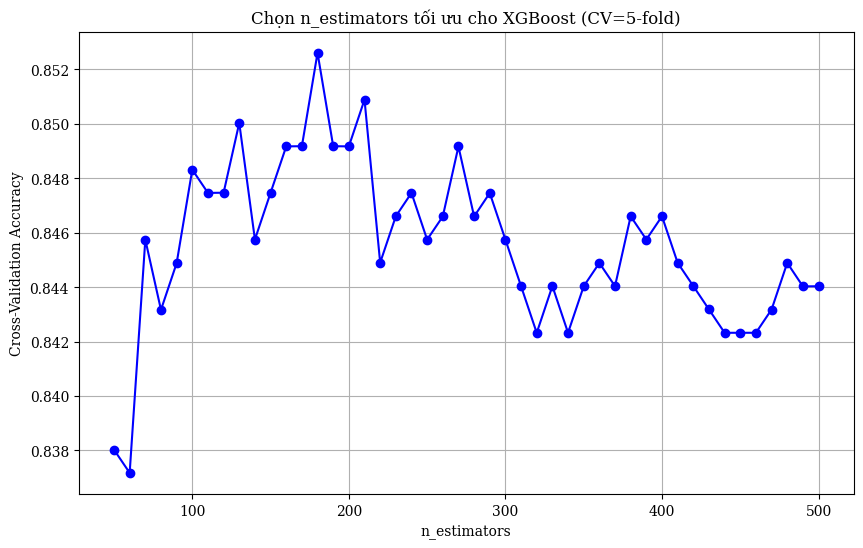

n_estimators tối ưu (CV): 180

Độ chính xác XGBoost trên tập validation: 0.8612
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       182
           1       0.88      0.85      0.87       207

    accuracy                           0.86       389
   macro avg       0.86      0.86      0.86       389
weighted avg       0.86      0.86      0.86       389


Độ chính xác XGBoost trên tập test: 0.8355
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       182
           1       0.84      0.86      0.85       207

    accuracy                           0.84       389
   macro avg       0.84      0.83      0.83       389
weighted avg       0.84      0.84      0.84       389



In [116]:
# 1) Tìm & train model tốt nhất trên X_train
xgb_model, val_dt_acc, best_params = evaluate_val_xgb(
    X_dt_train, y_dt_train, X_dt_val, y_dt_val
)

# 2) Đánh giá test
test_dt_acc = evaluate_test_xgb(xgb_model, X_dt_test, y_dt_test)

Tìm n_estimators tối ưu cho XGBoost...


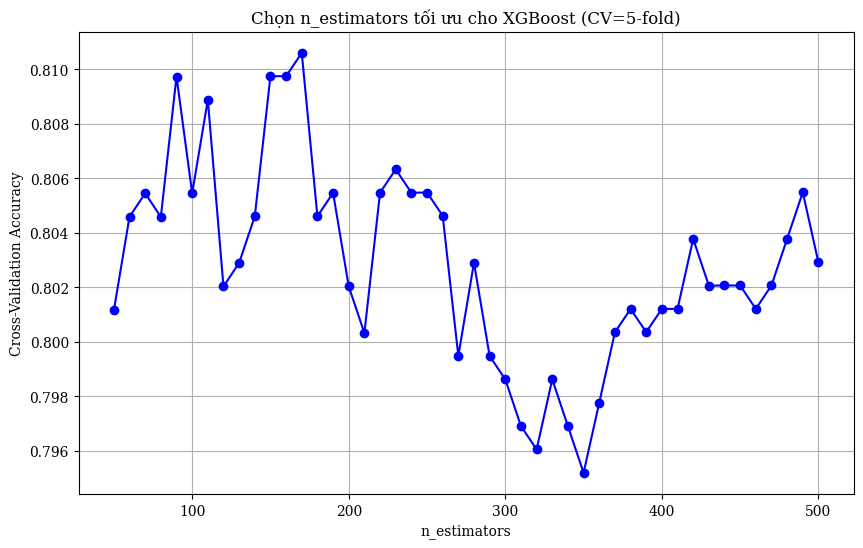

n_estimators tối ưu (CV): 170

Độ chính xác XGBoost trên tập validation: 0.8406
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       182
           1       0.85      0.86      0.85       207

    accuracy                           0.84       389
   macro avg       0.84      0.84      0.84       389
weighted avg       0.84      0.84      0.84       389


Độ chính xác XGBoost trên tập test: 0.8226
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       182
           1       0.82      0.86      0.84       207

    accuracy                           0.82       389
   macro avg       0.82      0.82      0.82       389
weighted avg       0.82      0.82      0.82       389



In [117]:
# 1) Tìm & train model tốt nhất trên X_train
xgb_model, val_fe_dt_acc, best_params = evaluate_val_xgb(
    X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val,
)

# 2) Đánh giá test
test_fe_dt_acc = evaluate_test_xgb(xgb_model, X_fe_dt_test, y_fe_dt_test)

In [123]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier # Changed from GradientBoostingClassifier
import numpy as np

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, step=0.01)
    max_depth = trial.suggest_int('max_depth', 3, 10, step=1)
    subsample = trial.suggest_float('subsample', 0.5, 1.0, step=0.01)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.01)

    model = XGBClassifier(n_estimators=n_estimators,
                          learning_rate=learning_rate,
                          max_depth=max_depth,
                          subsample=subsample,
                          colsample_bytree=colsample_bytree,
                          random_state=SEED,
                          use_label_encoder=False,
                          eval_metric='logloss') # Added XGBoost specific parameters
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_xgb_model = XGBClassifier(
    n_estimators=trial.params['n_estimators'],
    learning_rate=trial.params['learning_rate'],
    max_depth=trial.params['max_depth'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree'],
    random_state=SEED,
    use_label_encoder=False,
    eval_metric='logloss'
) # Changed model name and added XGBoost params

best_xgb_model.fit(X_train, y_train) # Changed model name

# Evaluate on the validation set
val_pred = best_xgb_model.predict(X_val) # Changed model name
val_acc_optuna = accuracy_score(y_val, val_pred)
print(f"\nĐộ chính xác XGBoost trên tập validation (Optuna): {val_acc_optuna:.4f}") # Changed model name
print("Classification Report:")
print(classification_report(y_val, val_pred))

# Evaluate on the test set
test_acc_optuna = evaluate_test_xgb(best_xgb_model, X_test, y_test) # Changed model name

[I 2025-10-01 15:43:45,480] A new study created in memory with name: no-name-b5eed4c4-4a2f-429e-a347-8ed70cdd444e
[I 2025-10-01 15:43:45,848] Trial 0 finished with value: 0.8654524778988298 and parameters: {'n_estimators': 180, 'learning_rate': 0.04, 'max_depth': 9, 'subsample': 0.62, 'colsample_bytree': 0.59}. Best is trial 0 with value: 0.8654524778988298.
[I 2025-10-01 15:43:46,142] Trial 1 finished with value: 0.8594475624518543 and parameters: {'n_estimators': 330, 'learning_rate': 0.21000000000000002, 'max_depth': 3, 'subsample': 0.86, 'colsample_bytree': 0.8500000000000001}. Best is trial 0 with value: 0.8654524778988298.
[I 2025-10-01 15:43:46,575] Trial 2 finished with value: 0.8603095997945782 and parameters: {'n_estimators': 430, 'learning_rate': 0.2, 'max_depth': 5, 'subsample': 0.78, 'colsample_bytree': 0.66}. Best is trial 0 with value: 0.8654524778988298.
[I 2025-10-01 15:43:46,737] Trial 3 finished with value: 0.8637284032133816 and parameters: {'n_estimators': 60, 'lea

Best trial:
  Value: 0.8843035838743993
  Params: 
    n_estimators: 270
    learning_rate: 0.02
    max_depth: 7
    subsample: 0.95
    colsample_bytree: 0.64

Độ chính xác XGBoost trên tập validation (Optuna): 0.9049
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       182
           1       0.93      0.89      0.91       207

    accuracy                           0.90       389
   macro avg       0.90      0.91      0.90       389
weighted avg       0.91      0.90      0.90       389


Độ chính xác XGBoost trên tập test: 0.8843
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       182
           1       0.88      0.91      0.89       207

    accuracy                           0.88       389
   macro avg       0.89      0.88      0.88       389
weighted avg       0.88      0.88      0.88       389



In [124]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, step=0.01)
    max_depth = trial.suggest_int('max_depth', 3, 10, step=1)
    subsample = trial.suggest_float('subsample', 0.5, 1.0, step=0.01)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.01)

    model = XGBClassifier(n_estimators=n_estimators,
                          learning_rate=learning_rate,
                          max_depth=max_depth,
                          subsample=subsample,
                          colsample_bytree=colsample_bytree,
                          random_state=SEED,
                          use_label_encoder=False,
                          eval_metric='logloss') # Added XGBoost specific parameters
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(model, X_fe_train, y_fe_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_xgb_model = XGBClassifier(
    n_estimators=trial.params['n_estimators'],
    learning_rate=trial.params['learning_rate'],
    max_depth=trial.params['max_depth'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree'],
    random_state=SEED,
    use_label_encoder=False,
    eval_metric='logloss'
) # Changed model name and added XGBoost params

best_xgb_model.fit(X_fe_train, y_fe_train) # Changed model name

# Evaluate on the validation set
val_pred = best_xgb_model.predict(X_fe_val) # Changed model name
val_acc_optuna = accuracy_score(y_fe_val, val_pred)
print(f"\nĐộ chính xác XGBoost trên tập validation (Optuna): {val_acc_optuna:.4f}") # Changed model name
print("Classification Report:")
print(classification_report(y_fe_val, val_pred))

# Evaluate on the test set
test_acc_optuna = evaluate_test_xgb(best_xgb_model, X_fe_test, y_fe_test) # Changed model name

[I 2025-10-01 15:46:18,950] A new study created in memory with name: no-name-901f3708-b5ed-45f5-a5fe-8323bff376e5
[I 2025-10-01 15:46:19,654] Trial 0 finished with value: 0.8269102380690365 and parameters: {'n_estimators': 240, 'learning_rate': 0.28, 'max_depth': 8, 'subsample': 0.98, 'colsample_bytree': 0.51}. Best is trial 0 with value: 0.8269102380690365.
[I 2025-10-01 15:46:20,547] Trial 1 finished with value: 0.8140383698323612 and parameters: {'n_estimators': 350, 'learning_rate': 0.18000000000000002, 'max_depth': 7, 'subsample': 0.6799999999999999, 'colsample_bytree': 0.9199999999999999}. Best is trial 0 with value: 0.8269102380690365.
[I 2025-10-01 15:46:21,367] Trial 2 finished with value: 0.8294486629250578 and parameters: {'n_estimators': 250, 'learning_rate': 0.01, 'max_depth': 10, 'subsample': 0.73, 'colsample_bytree': 0.63}. Best is trial 2 with value: 0.8294486629250578.
[I 2025-10-01 15:46:21,844] Trial 3 finished with value: 0.8200432852793368 and parameters: {'n_estim

Best trial:
  Value: 0.844044605847181
  Params: 
    n_estimators: 500
    learning_rate: 0.01
    max_depth: 10
    subsample: 0.91
    colsample_bytree: 0.79

Độ chính xác XGBoost trên tập validation (Optuna): 0.8946
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       182
           1       0.91      0.89      0.90       207

    accuracy                           0.89       389
   macro avg       0.89      0.89      0.89       389
weighted avg       0.90      0.89      0.89       389


Độ chính xác XGBoost trên tập test: 0.8638
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       182
           1       0.86      0.89      0.87       207

    accuracy                           0.86       389
   macro avg       0.86      0.86      0.86       389
weighted avg       0.86      0.86      0.86       389



In [125]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, step=0.01)
    max_depth = trial.suggest_int('max_depth', 3, 10, step=1)
    subsample = trial.suggest_float('subsample', 0.5, 1.0, step=0.01)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.01)

    model = XGBClassifier(n_estimators=n_estimators,
                          learning_rate=learning_rate,
                          max_depth=max_depth,
                          subsample=subsample,
                          colsample_bytree=colsample_bytree,
                          random_state=SEED,
                          use_label_encoder=False,
                          eval_metric='logloss') # Added XGBoost specific parameters
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(model, X_dt_train, y_dt_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_xgb_model = XGBClassifier(
    n_estimators=trial.params['n_estimators'],
    learning_rate=trial.params['learning_rate'],
    max_depth=trial.params['max_depth'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree'],
    random_state=SEED,
    use_label_encoder=False,
    eval_metric='logloss'
) # Changed model name and added XGBoost params

best_xgb_model.fit(X_dt_train, y_dt_train) # Changed model name

# Evaluate on the validation set
val_pred = best_xgb_model.predict(X_dt_val) # Changed model name
val_acc_optuna = accuracy_score(y_dt_val, val_pred)
print(f"\nĐộ chính xác XGBoost trên tập validation (Optuna): {val_acc_optuna:.4f}") # Changed model name
print("Classification Report:")
print(classification_report(y_dt_val, val_pred))

# Evaluate on the test set
test_acc_optuna = evaluate_test_xgb(best_xgb_model, X_dt_test, y_dt_test) # Changed model name

[I 2025-10-01 15:48:51,269] A new study created in memory with name: no-name-f6ce1d25-416d-433c-8940-1f2a7686ec1f
[I 2025-10-01 15:48:52,117] Trial 0 finished with value: 0.8465830307032025 and parameters: {'n_estimators': 260, 'learning_rate': 0.060000000000000005, 'max_depth': 8, 'subsample': 0.52, 'colsample_bytree': 0.56}. Best is trial 0 with value: 0.8465830307032025.
[I 2025-10-01 15:48:52,254] Trial 1 finished with value: 0.8500165070980522 and parameters: {'n_estimators': 50, 'learning_rate': 0.3, 'max_depth': 5, 'subsample': 0.87, 'colsample_bytree': 0.75}. Best is trial 1 with value: 0.8500165070980522.
[I 2025-10-01 15:48:52,465] Trial 2 finished with value: 0.8260078500421848 and parameters: {'n_estimators': 60, 'learning_rate': 0.13, 'max_depth': 4, 'subsample': 0.5700000000000001, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.8500165070980522.
[I 2025-10-01 15:48:52,692] Trial 3 finished with value: 0.8551630534463153 and parameters: {'n_estimators': 60, 'learn

Best trial:
  Value: 0.8705990242470929
  Params: 
    n_estimators: 120
    learning_rate: 0.03
    max_depth: 10
    subsample: 0.89
    colsample_bytree: 0.8200000000000001

Độ chính xác XGBoost trên tập validation (Optuna): 0.8946
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       182
           1       0.91      0.89      0.90       207

    accuracy                           0.89       389
   macro avg       0.89      0.89      0.89       389
weighted avg       0.89      0.89      0.89       389


Độ chính xác XGBoost trên tập test: 0.8586
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       182
           1       0.85      0.89      0.87       207

    accuracy                           0.86       389
   macro avg       0.86      0.86      0.86       389
weighted avg       0.86      0.86      0.86       389



## 4.Result Visualization

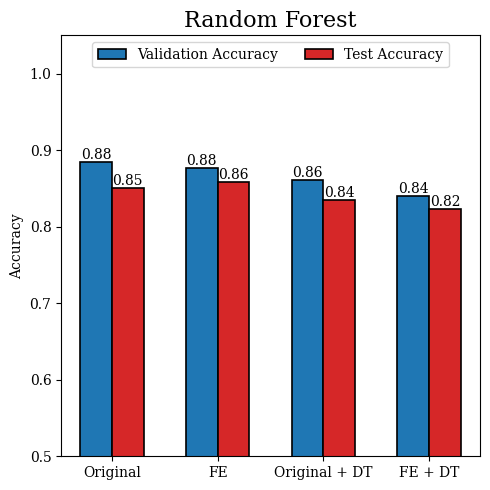

In [120]:
plt.rcParams['font.family'] = 'Serif'

labels = ['Original', 'FE', 'Original + DT', "FE + DT"]
val_accs = [val_acc, val_fe_acc, val_dt_acc, val_fe_dt_acc]
test_accs = [test_acc, test_fe_acc, test_dt_acc, test_fe_dt_acc]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(5, 5))

rects1 = ax.bar(x - width/2, val_accs,  width,
                label='Validation Accuracy',
                color='tab:blue', edgecolor='black', linewidth=1.2)
rects2 = ax.bar(x + width/2, test_accs, width,
                label='Test Accuracy',
                color='tab:red', edgecolor='black', linewidth=1.2)

ax.set_ylim(0.5, 1.05)
ax.set_ylabel('Accuracy')
ax.set_title('Random Forest', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc="upper center")

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(f'{h:.2f}', xy=(rect.get_x()+rect.get_width()/2, h),
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.savefig("accuracy_comparison.png", dpi=300, bbox_inches="tight")
fig.savefig("accuracy_comparison.pdf", bbox_inches="tight")
plt.show()


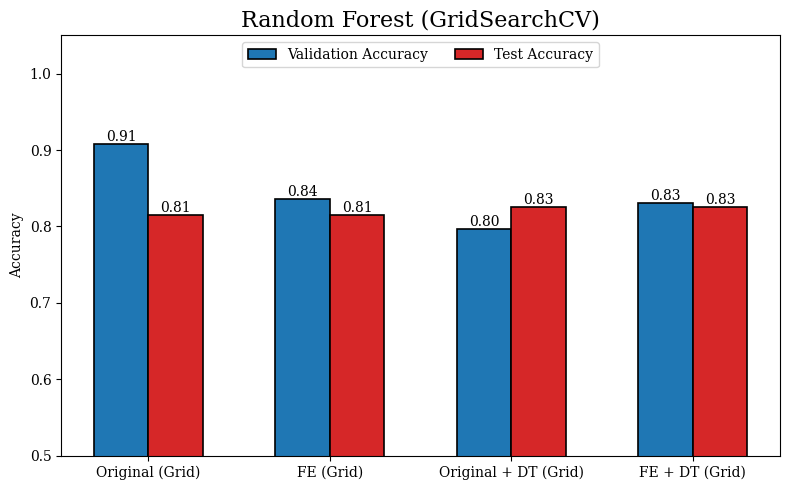

In [121]:
plt.rcParams['font.family'] = 'Serif'

labels = ['Original (Grid)', 'FE (Grid)', 'Original + DT (Grid)', "FE + DT (Grid)"]
val_accs = [valgrid_acc, valgrid_fe_acc, valgrid_dt_acc, valgrid_fe_dt_acc]
test_accs = [testgrid_fe_acc, testgrid_fe_acc, testgrid_fe_dt_acc, testgrid_fe_dt_acc]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(8, 5))

rects1 = ax.bar(x - width/2, val_accs,  width,
                label='Validation Accuracy',
                color='tab:blue', edgecolor='black', linewidth=1.2)
rects2 = ax.bar(x + width/2, test_accs, width,
                label='Test Accuracy',
                color='tab:red', edgecolor='black', linewidth=1.2)

ax.set_ylim(0.5, 1.05)
ax.set_ylabel('Accuracy')
ax.set_title('Random Forest (GridSearchCV)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc="upper center")

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(f'{h:.2f}', xy=(rect.get_x()+rect.get_width()/2, h),
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.savefig("accuracy_comparison.png", dpi=300, bbox_inches="tight")
fig.savefig("accuracy_comparison.pdf", bbox_inches="tight")
plt.show()

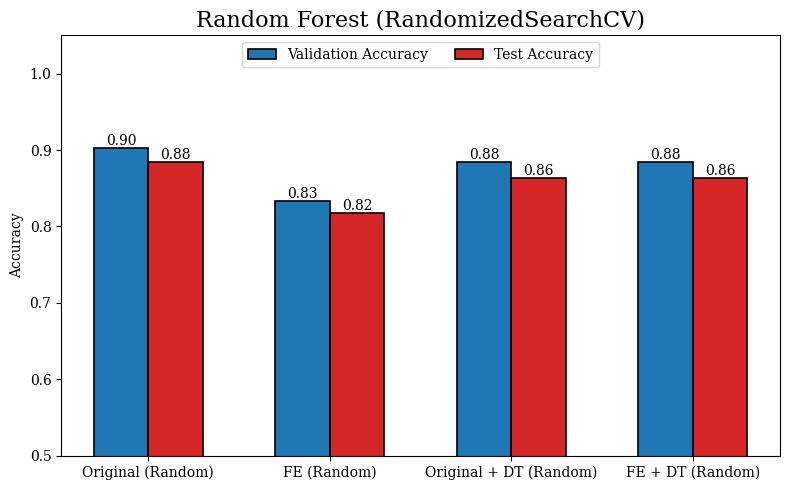

In [122]:
plt.rcParams['font.family'] = 'Serif'

labels = ['Original (Random)', 'FE (Random)', 'Original + DT (Random)', "FE + DT (Random)"]
val_accs = [valrd_acc, valrd_fe_acc, valrd_dt_acc, valrd_dt_acc]
test_accs = [testrd_acc, testrd_fe_acc, testrd_fe_dt_acc, testrd_fe_dt_acc]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(8, 5))

rects1 = ax.bar(x - width/2, val_accs,  width,
                label='Validation Accuracy',
                color='tab:blue', edgecolor='black', linewidth=1.2)
rects2 = ax.bar(x + width/2, test_accs, width,
                label='Test Accuracy',
                color='tab:red', edgecolor='black', linewidth=1.2)

ax.set_ylim(0.5, 1.05)
ax.set_ylabel('Accuracy')
ax.set_title('Random Forest (RandomizedSearchCV)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc="upper center")

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(f'{h:.2f}', xy=(rect.get_x()+rect.get_width()/2, h),
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.savefig("accuracy_comparison.png", dpi=300, bbox_inches="tight")
fig.savefig("accuracy_comparison.pdf", bbox_inches="tight")
plt.show()